In [2]:
import os
import copy
import csv
import json
import time
import torch
import pandas as pd
import random
import datetime
import shutil
import numpy as np
from tqdm import tqdm
from PIL import Image
from itertools import chain
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import logging
import pickle
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import sys
sys.path.append(r'C:/Users/1\anaconda3\Lib\site-packages\scipy\__init__.py')

c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#유효성 증빙서류 저장 경로
save_path='C:/Users/1'

In [4]:
# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.DEBUG)

# log 출력 형식
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# log 출력
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


# log를 파일에 출력
logger.info(f'로그파일을 저장할 경로는 {save_path}입니다')
file_handler = logging.FileHandler(save_path+'/'+'LIFEISSUE_Model.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

2024-11-10 08:54:00,668 - root - INFO - 로그파일을 저장할 경로는 C:/Users/1입니다


In [5]:
# origin_path는 원천데이터(이미지데이터)가 저장되어있는 경로로 지정해야합니다.
# label_path는 라벨링데이터가 저장되어있는 경로로 지정해야합니다.

origin_path='C:/Users/1/106.지능형 양봉 데이터/01-1.정식개방데이터/Training/01.원천데이터'
label_path='C:/Users/1/106.지능형 양봉 데이터/01-1.정식개방데이터/Training/02.라벨링데이터'

# 데이터 불러오기

# 1.원천데이터, 라벨링데이터 경로에서 직접 불러오기

In [6]:
# 1.원천데이터 라벨링데이터 경로에서 직접불러오기


class DAnn_check():
    def __init__(self,img_root,label_root):
        self.img_root=img_root #C:/Users/user/Desktop/test/원천데이터
        self.label_root=label_root #C:/Users/user/Desktop/test/라벨링데이터
        
    def check(self):
        random_seed=42
        random.seed(random_seed)
        dict_B={}
        print('백묵명 음성 양성 Annotation 개수 추출')
        
        for i in os.listdir(self.img_root+'/'+'실제데이터'+'/'+'Bounding Box'):
            logger.info('백묵병 데이터의 Annotation 개수를 측정합니다')
            if (i=='02.생애이슈(백묵병_음성)')|(i=='12.생애이슈(백묵병_양성)'):
                print(i)
                dict_B[f'num_of_{i}']=0
                #dict_B[f'num_of_{i}_file']=0
               
                for j in tqdm(os.listdir(self.img_root+'/'+'실제데이터'+'/'+'Bounding Box'+'/'+i)):
                    with open(self.label_root+'/'+'실제데이터'+'/'+'Bounding Box'+'/'+i+'/'+j.split('.')[0]+'.json','r',encoding='UTF-8') as Bounding_d:
                        json_file_D=json.load(Bounding_d)
                        dict_B[f'num_of_{i}'] += len(json_file_D['ANNOTATION_INFO'])
                        ann_Bounding=(dict_B.values())
            else:
                pass
        print(f'음성, 양성 데이터의 각각 Annotation 개수는 {ann_Bounding}개 입니다.')
        logger.info(f'백묵병 음성, 양성 데이터의 Annotation 개수는 {ann_Bounding}개 입니다.')
        return ann_Bounding

In [7]:
no_disease_ann, disease_ann=DAnn_check(img_root=origin_path,label_root=label_path).check()

2024-11-10 08:54:16,459 - root - INFO - 백묵병 데이터의 Annotation 개수를 측정합니다


백묵명 음성 양성 Annotation 개수 추출
02.생애이슈(백묵병_음성)


100%|██████████| 16120/16120 [01:40<00:00, 159.81it/s]
2024-11-10 08:55:58,045 - root - INFO - 백묵병 데이터의 Annotation 개수를 측정합니다


12.생애이슈(백묵병_양성)


100%|██████████| 8400/8400 [00:52<00:00, 160.59it/s]
2024-11-10 08:56:50,578 - root - INFO - 백묵병 음성, 양성 데이터의 Annotation 개수는 dict_values([159883, 81549])개 입니다.


음성, 양성 데이터의 각각 Annotation 개수는 dict_values([159883, 81549])개 입니다.


In [8]:
import os
import random
import json
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

class D_Load():
    def __init__(self, img_root, label_root, class_list, Neg_ann, Pos_ann, resize=112, subset_ratio=0.1):
        self.img_root = img_root
        self.label_root = label_root
        self.class_list = class_list
        self.Neg_ann = int(Neg_ann * subset_ratio)  # 음성 데이터 파일 수의 1/10
        self.Pos_ann = int(Pos_ann * subset_ratio)  # 양성 데이터 파일 수의 1/10
        self.trans_tensor = transforms.ToTensor()
        self.trans_resize = transforms.Resize((resize, resize))

    def D_Loading(self):
        random_seed = 42
        random.seed(random_seed)
        
        data_dict_D = {'음성': [], '양성': []}
        
        # 음성 데이터 로드 및 샘플링 (파일 수 제한)
        neg_path = os.path.join(self.img_root, '실제데이터', 'Bounding Box', '02.생애이슈(백묵병_음성)')
        neg_files = os.listdir(neg_path)
        neg_sample_files = random.sample(neg_files, min(len(neg_files), self.Neg_ann))  # 음성 파일 중에서 1/10만 선택

        for j in tqdm(neg_sample_files, desc='음성 데이터 로딩'):
            with open(os.path.join(self.label_root, '실제데이터', 'Bounding Box', '02.생애이슈(백묵병_음성)', j.split('.')[0] + '.json'), 'r', encoding='UTF-8') as f:
                jsonfile_D = json.load(f)
                image_file_name = jsonfile_D['IMAGE']['IMAGE_FILE_NAME']
                
                # 첫 번째 Annotation 정보만 사용
                if jsonfile_D['ANNOTATION_INFO']:
                    k = 0  # 첫 번째 Annotation만 사용
                    x_data = self.trans_tensor(
                        self.trans_resize(
                            Image.open(os.path.join(neg_path, j)).crop(
                                (jsonfile_D['ANNOTATION_INFO'][k]['XTL'], jsonfile_D['ANNOTATION_INFO'][k]['YTL'],
                                 jsonfile_D['ANNOTATION_INFO'][k]['XBR'], jsonfile_D['ANNOTATION_INFO'][k]['YBR'])
                            )
                        )
                    )
                    data_dict_D['음성'].append([x_data, 0, image_file_name])

        # 양성 데이터 로드 및 샘플링 (파일 수 제한)
        pos_path = os.path.join(self.img_root, '실제데이터', 'Bounding Box', '12.생애이슈(백묵병_양성)')
        pos_files = os.listdir(pos_path)
        pos_sample_files = random.sample(pos_files, min(len(pos_files), self.Pos_ann))  # 양성 파일 중에서 1/10만 선택

        for l in tqdm(pos_sample_files, desc='양성 데이터 로딩'):
            with open(os.path.join(self.label_root, '실제데이터', 'Bounding Box', '12.생애이슈(백묵병_양성)', l.split('.')[0] + '.json'), 'r', encoding='UTF-8') as f:
                jsonfile_D = json.load(f)
                image_file_name = jsonfile_D['IMAGE']['IMAGE_FILE_NAME']
                
                # 첫 번째 Annotation 정보만 사용
                if jsonfile_D['ANNOTATION_INFO']:
                    m = 0  # 첫 번째 Annotation만 사용
                    x_data = self.trans_tensor(
                        self.trans_resize(
                            Image.open(os.path.join(pos_path, l)).crop(
                                (jsonfile_D['ANNOTATION_INFO'][m]['XTL'], jsonfile_D['ANNOTATION_INFO'][m]['YTL'],
                                 jsonfile_D['ANNOTATION_INFO'][m]['XBR'], jsonfile_D['ANNOTATION_INFO'][m]['YBR'])
                            )
                        )
                    )
                    data_dict_D['양성'].append([x_data, 1, image_file_name])

        # 음성 및 양성 데이터를 합치기
        return_list_D = data_dict_D['음성'] + data_dict_D['양성']
        
        return return_list_D

# 데이터를 로드하면서 각 클래스에서 1/10 비율로 파일을 무작위로 샘플링
dataset = D_Load(img_root=origin_path, label_root=label_path, Neg_ann=159883, Pos_ann=81549, class_list=['LA_NEG', 'LA_POS'], subset_ratio=0.1).D_Loading()
logger.info('데이터 로딩이 끝났습니다.')


양성 데이터 로딩: 100%|██████████| 8154/8154 [03:23<00:00, 40.17it/s]
2024-11-10 09:06:17,198 - root - INFO - 데이터 로딩이 끝났습니다.


In [15]:
import torchvision.transforms as transforms
from PIL import Image
import os

# ToPILImage 변환기 생성
to_pil = transforms.ToPILImage()

# 예시: dataset이 [(tensor, label, file_name), ...] 형태라고 가정할 때
output_dir = 'C:/Users/1/Desktop/지능형 양봉 데이터/변환된_이미지'  # 저장할 디렉토리
os.makedirs(output_dir, exist_ok=True)

for idx, (tensor_image, label, file_name) in enumerate(dataset):
    # 텐서를 PIL 이미지로 변환
    pil_image = to_pil(tensor_image)

    # 파일 이름 생성 (예시로 index와 레이블을 사용)
    save_name = f'{label}_{idx}.png'
    save_path = os.path.join(output_dir, save_name)

    # 이미지 저장
    pil_image.save(save_path)

print("텐서 이미지를 저장했습니다.")


텐서 이미지를 저장했습니다.


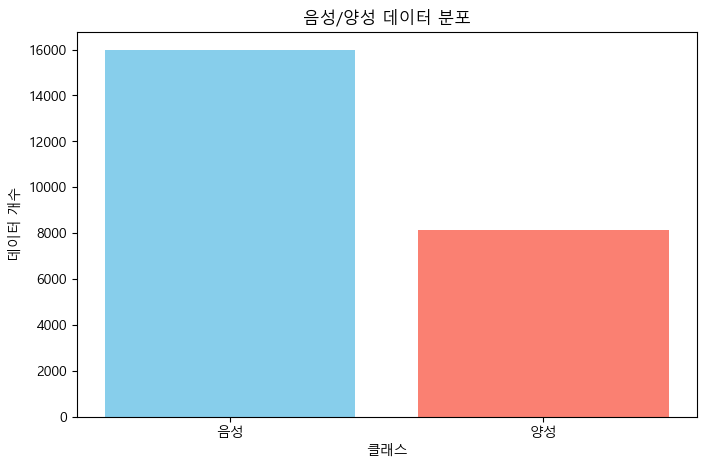

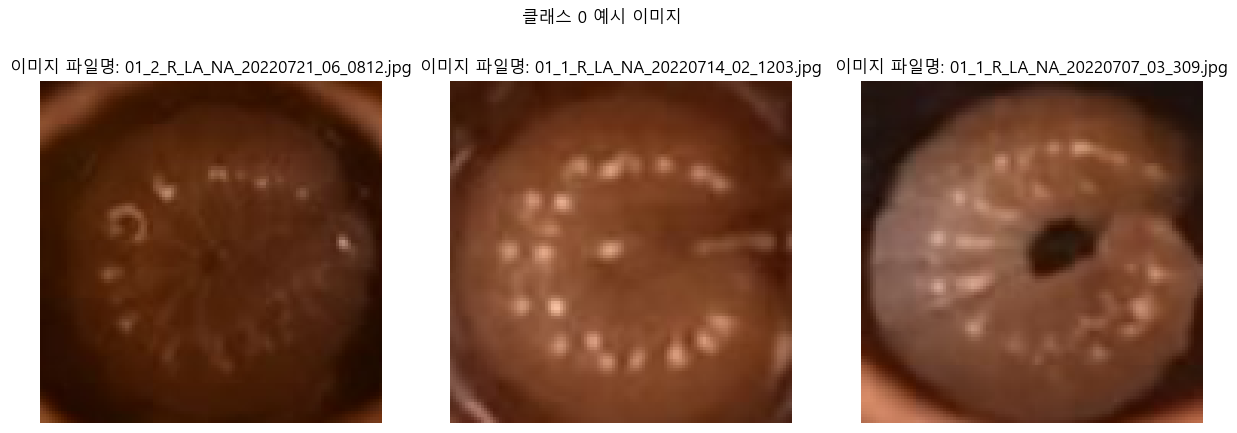

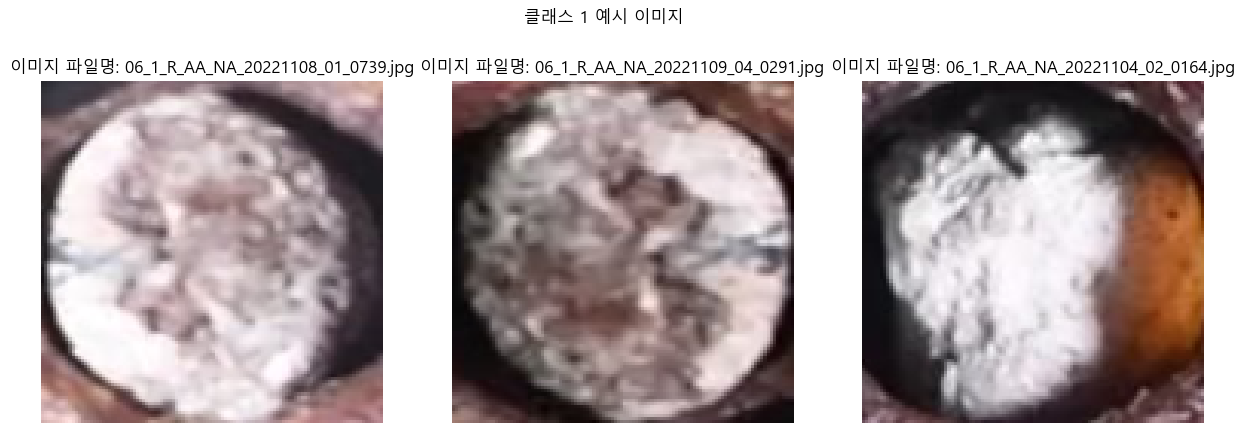


위치 추정 통계량 (WRB 채널별):
클래스 0: W 평균 = 0.3607, R 평균 = 0.5628, B 평균 = 0.1837
클래스 0: W 중앙값 = 0.3569, R 중앙값 = 0.5686, B 중앙값 = 0.1725
클래스 0: W 표준편차 = 0.0816, R 표준편차 = 0.0863, B 표준편차 = 0.0818
클래스 0: W 25번째 백분위수 = 0.3079, R 25번째 백분위수 = 0.5101, B 25번째 백분위수 = 0.1278
클래스 1: W 평균 = 0.5169, R 평균 = 0.5492, B 평균 = 0.5007
클래스 1: W 중앙값 = 0.5173, R 중앙값 = 0.5725, B 중앙값 = 0.4863
클래스 1: W 표준편차 = 0.3041, R 표준편차 = 0.2981, B 표준편차 = 0.3112
클래스 1: W 25번째 백분위수 = 0.2300, R 25번째 백분위수 = 0.2761, B 25번째 백분위수 = 0.2017


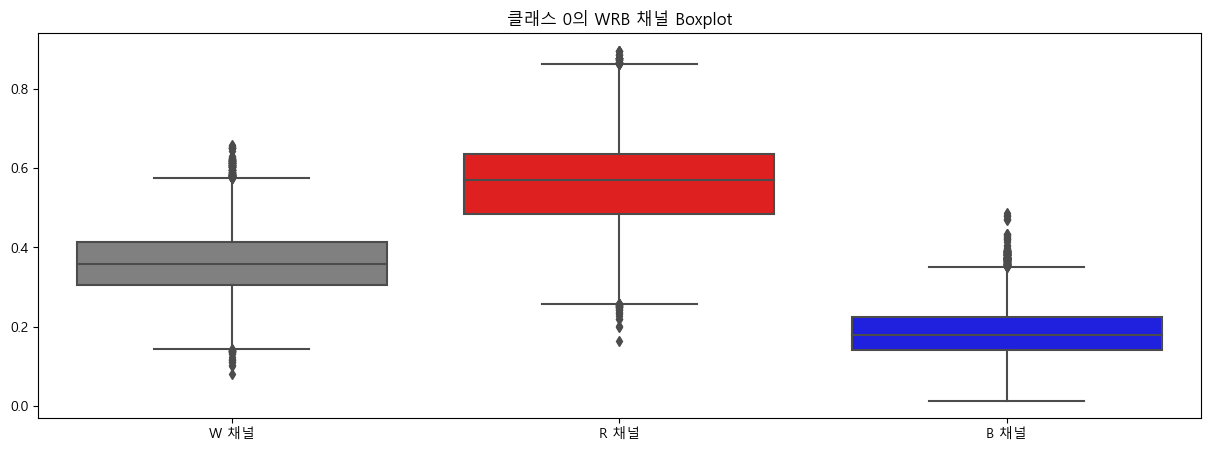

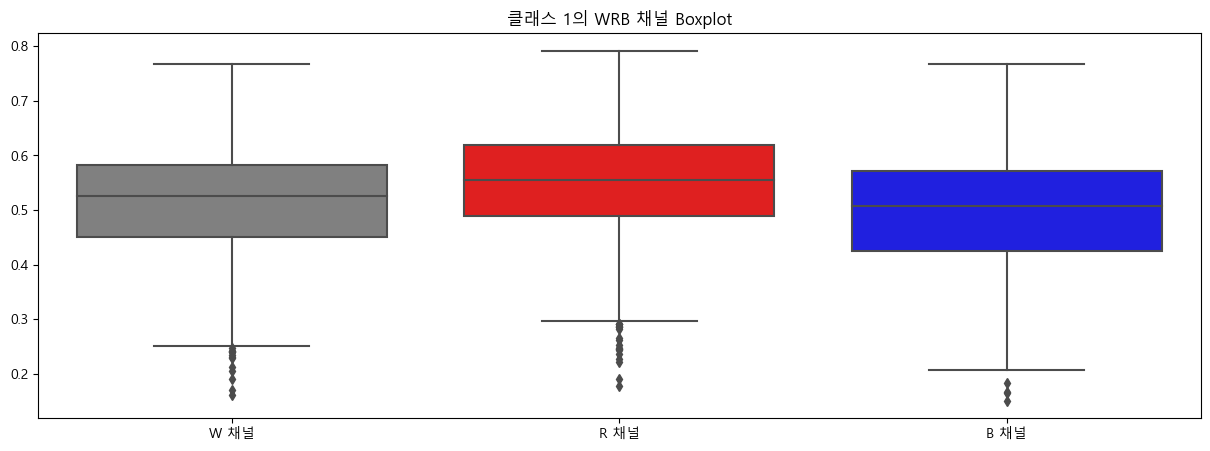

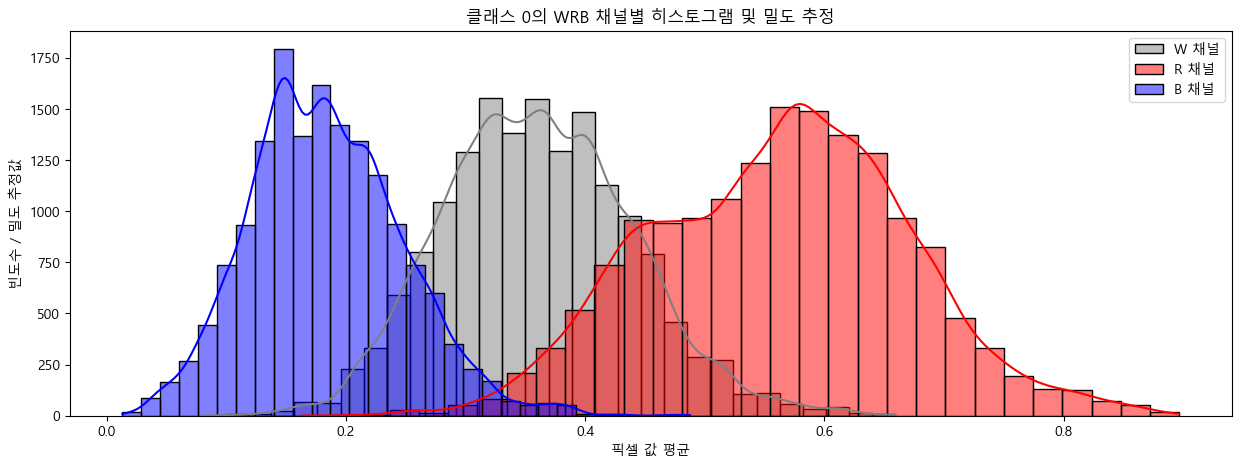

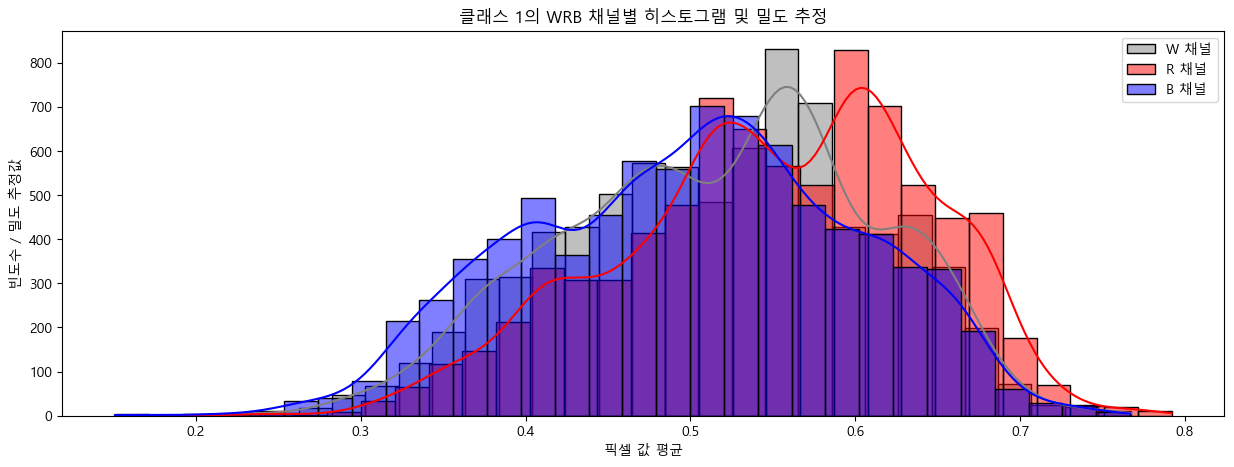

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms

# 한글 폰트 설정 (윈도우 사용 시)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def calculate_wrb_channels(img_tensor):
    """
    RGB 텐서에서 WRB(흰색, 붉은색, 파란색) 채널을 계산합니다.
    흰색은 각 채널의 평균 값으로 정의되며, 특정 임계값에 따라 조정될 수 있습니다.
    
    Parameters:
        img_tensor (torch.Tensor): [3, H, W] 형태의 텐서 (RGB 이미지).
        
    Returns:
        torch.Tensor: [3, H, W] 형태의 WRB 텐서.
    """
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    r_channel = img_array[0]
    g_channel = img_array[1]
    b_channel = img_array[2]
    
    # W (흰색) 채널을 계산: R, G, B 평균
    w_channel = (r_channel + g_channel + b_channel) / 3.0

    # 새로운 WRB 텐서 생성
    wrb_tensor = np.stack([w_channel, r_channel, b_channel], axis=0)  # [W, R, B] 순서
    return torch.tensor(wrb_tensor)

def perform_eda_wrb(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터 개수 확인
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # 막대 그래프 시각화
    plt.figure(figsize=(8, 5))
    plt.bar(unique_labels, counts, tick_label=['음성', '양성'], color=['skyblue', 'salmon'])
    plt.xlabel('클래스')
    plt.ylabel('데이터 개수')
    plt.title('음성/양성 데이터 분포')
    plt.show()
    
    # 각 클래스에서 임의의 이미지 3개씩 시각화
    for label in unique_labels:
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'클래스 {label} 예시 이미지')
        label_items = [item for item in dataset if item[1] == label]
        num_images = min(3, len(label_items))
        
        for i in range(num_images):
            img_tensor = label_items[i][0]
            img = transforms.ToPILImage()(img_tensor)  # 텐서를 PIL 이미지로 변환
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'이미지 파일명: {label_items[i][2]}')
        plt.show()
    
    # 위치 추정 통계량 계산 (WRB 채널별 평균, 중앙값)
    print("\n위치 추정 통계량 (WRB 채널별):")
    for label in unique_labels:
        label_items = [calculate_wrb_channels(item[0]) for item in dataset if item[1] == label]
        w_means = []
        r_means = []
        b_means = []
        w_medians = []
        r_medians = []
        b_medians = []
        w_stds = []
        r_stds = []
        b_stds = []
        w_percentiles = []
        r_percentiles = []
        b_percentiles = []
        
        for img_tensor in label_items:
            img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
            w_channel = img_array[0].flatten()  # White 채널
            r_channel = img_array[1].flatten()  # Red 채널
            b_channel = img_array[2].flatten()  # Blue 채널
            
            w_means.append(np.mean(w_channel))
            r_means.append(np.mean(r_channel))
            b_means.append(np.mean(b_channel))
            
            w_medians.append(np.median(w_channel))
            r_medians.append(np.median(r_channel))
            b_medians.append(np.median(b_channel))
            
            w_stds.append(np.std(w_channel))
            r_stds.append(np.std(r_channel))
            b_stds.append(np.std(b_channel))
            
            w_percentiles.append(np.percentile(w_channel, 25))
            r_percentiles.append(np.percentile(r_channel, 25))
            b_percentiles.append(np.percentile(b_channel, 25))
        
        print(f"클래스 {label}: W 평균 = {np.mean(w_means):.4f}, R 평균 = {np.mean(r_means):.4f}, B 평균 = {np.mean(b_means):.4f}")
        print(f"클래스 {label}: W 중앙값 = {np.median(w_medians):.4f}, R 중앙값 = {np.median(r_medians):.4f}, B 중앙값 = {np.median(b_medians):.4f}")
        print(f"클래스 {label}: W 표준편차 = {np.mean(w_stds):.4f}, R 표준편차 = {np.mean(r_stds):.4f}, B 표준편차 = {np.mean(b_stds):.4f}")
        print(f"클래스 {label}: W 25번째 백분위수 = {np.mean(w_percentiles):.4f}, R 25번째 백분위수 = {np.mean(r_percentiles):.4f}, B 25번째 백분위수 = {np.mean(b_percentiles):.4f}")
    
    # Boxplot 시각화 (WRB 채널별 평균 수집하여 박스플롯 생성)
    for label in unique_labels:
        label_items = [calculate_wrb_channels(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        r_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=[w_means, r_means, b_means], palette=['gray', 'r', 'b'])
        plt.xticks([0, 1, 2], ['W 채널', 'R 채널', 'B 채널'])
        plt.title(f"클래스 {label}의 WRB 채널 Boxplot")
        plt.show()
    
    # 빈도 테이블과 히스토그램 및 밀도 추정 (WRB 채널별)
    for label in unique_labels:
        label_items = [calculate_wrb_channels(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        r_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        plt.figure(figsize=(15, 5))
        sns.histplot(w_means, bins=30, color='gray', kde=True, label='W 채널')
        sns.histplot(r_means, bins=30, color='r', kde=True, label='R 채널')
        sns.histplot(b_means, bins=30, color='b', kde=True, label='B 채널')
        plt.xlabel('픽셀 값 평균')
        plt.ylabel('빈도수 / 밀도 추정값')
        plt.title(f'클래스 {label}의 WRB 채널별 히스토그램 및 밀도 추정')
        plt.legend()
        plt.show()
    
# WRB EDA 수행
perform_eda_wrb(dataset)



위치 추정 통계량 (흰색과 흰색이 아닌 것):
클래스 0: 흰색 평균 = 0.0004, 흰색이 아닌 것 평균 = 0.5624
클래스 0: 흰색 중앙값 = 0.0000, 흰색이 아닌 것 중앙값 = 0.5686
클래스 0: 흰색 표준편차 = 0.0058, 흰색이 아닌 것 표준편차 = 0.0866
클래스 1: 흰색 평균 = 0.2628, 흰색이 아닌 것 평균 = 0.2900
클래스 1: 흰색 중앙값 = 0.0000, 흰색이 아닌 것 중앙값 = 0.2333
클래스 1: 흰색 표준편차 = 0.4091, 흰색이 아닌 것 표준편차 = 0.2871


2024-11-10 09:15:20,254 - matplotlib.font_manager - DEBUG - findfont: Matching Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-11-10 09:15:20,268 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\1\\anaconda3\\envs\\new_env_name\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-11-10 09:15:20,271 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\1\\anaconda3\\envs\\new_env_name\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-11-10 09:15:20,271 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\1\\anaconda3\\envs\\new_env_name\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-B

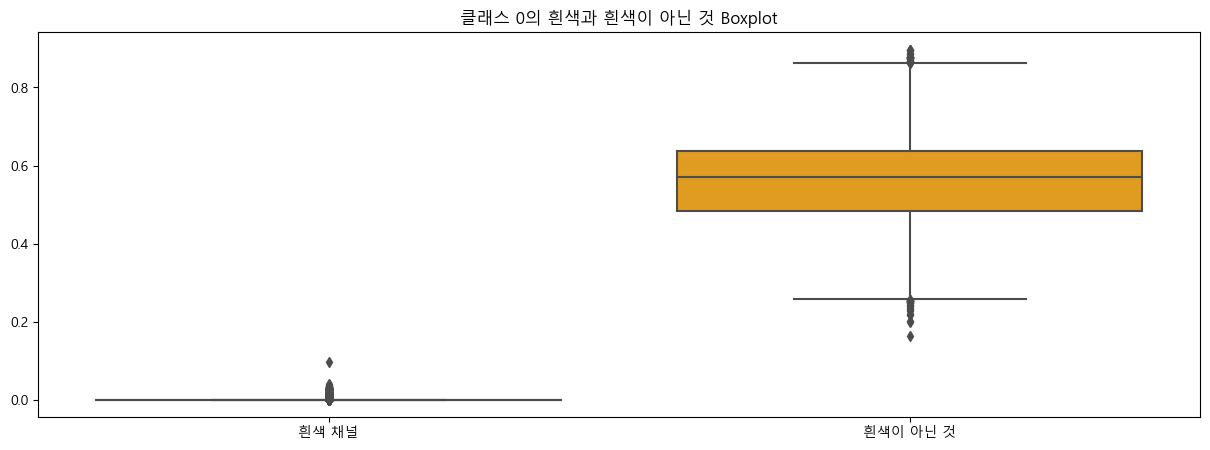

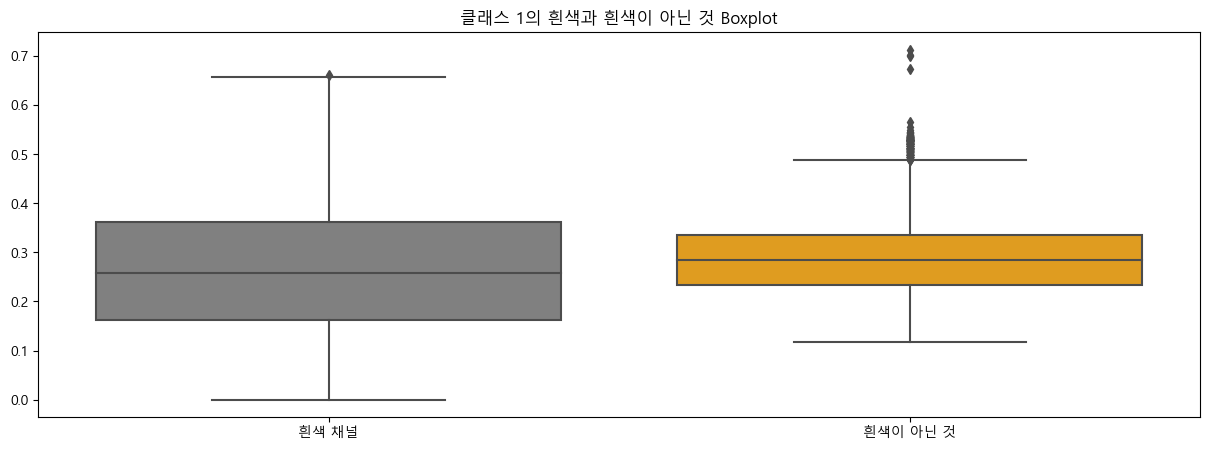

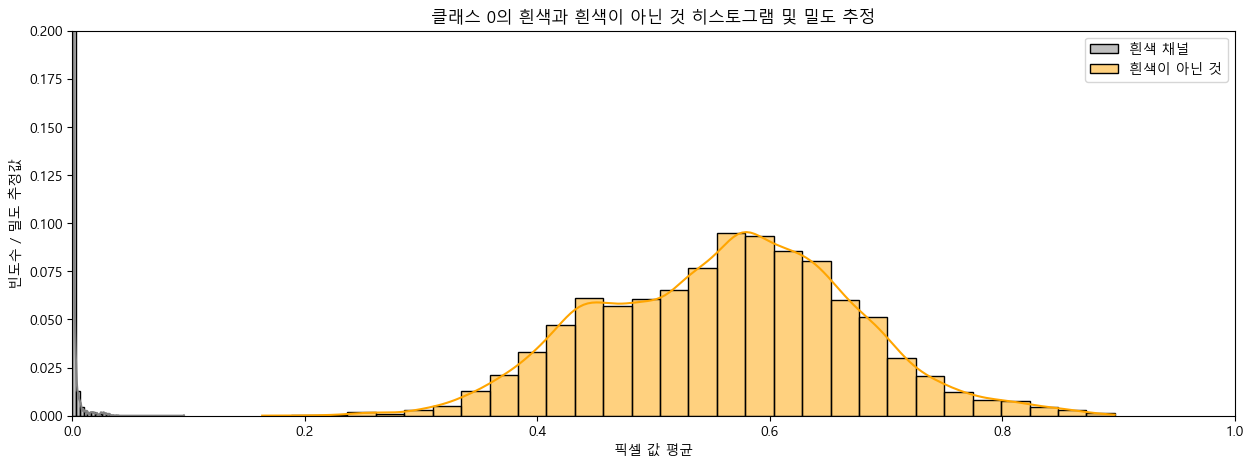

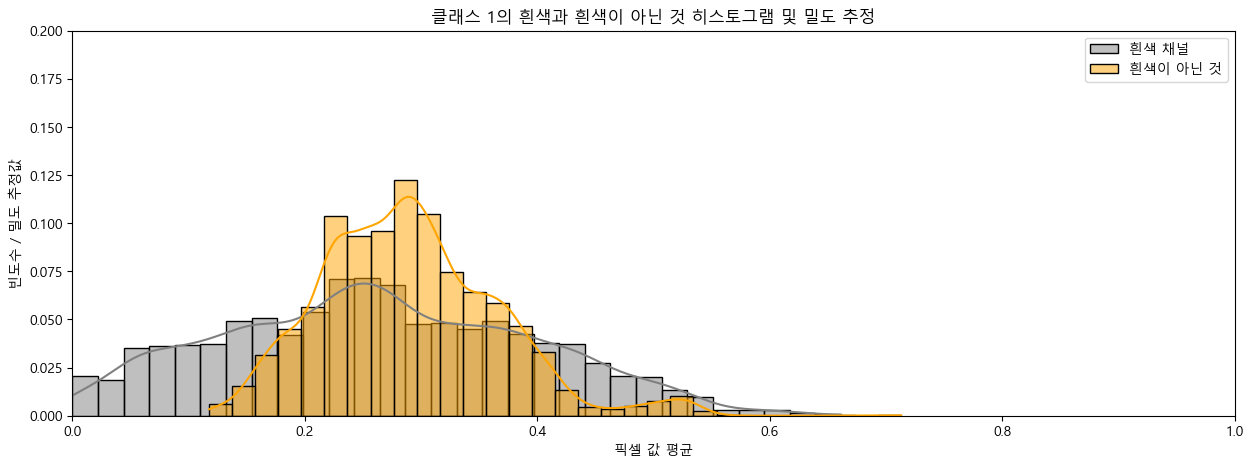

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms

# 한글 폰트 설정 (윈도우 사용 시)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def calculate_white_and_nonwhite(img_tensor):
    """
    RGB 텐서에서 흰색(W) 채널과 흰색이 아닌 나머지 채널을 계산합니다.
    흰색(W)은 R, G, B 평균으로 정의하고, 흰색이 아닌 것은 나머지 채널 값으로 정의합니다.
    
    Parameters:
        img_tensor (torch.Tensor): [3, H, W] 형태의 텐서 (RGB 이미지).
        
    Returns:
        torch.Tensor: [2, H, W] 형태의 텐서 (흰색, 흰색이 아닌 것).
    """
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    r_channel = img_array[0]
    g_channel = img_array[1]
    b_channel = img_array[2]
    
    # W (흰색) 채널을 계산: R, G, B 평균
    w_channel = np.where((r_channel > 0.8) & (g_channel > 0.8) & (b_channel > 0.8), 1.0, 0.0)

    # 흰색이 아닌 나머지 값 계산
    non_white_channel = np.maximum.reduce([r_channel, g_channel, b_channel]) - w_channel

    # 새로운 텐서 생성
    white_nonwhite_tensor = np.stack([w_channel, non_white_channel], axis=0)  # [W, Non-White] 순서
    return torch.tensor(white_nonwhite_tensor)

def perform_eda_white_nonwhite(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터 개수 확인
    unique_labels, counts = np.unique(labels, return_counts=True)

    
    # 위치 추정 통계량 계산 (흰색과 흰색이 아닌 것)
    print("\n위치 추정 통계량 (흰색과 흰색이 아닌 것):")
    for label in unique_labels:
        label_items = [calculate_white_and_nonwhite(item[0]) for item in dataset if item[1] == label]
        w_means = []
        nonwhite_means = []
        w_medians = []
        nonwhite_medians = []
        w_stds = []
        nonwhite_stds = []
        
        for img_tensor in label_items:
            img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
            w_channel = img_array[0].flatten()  # White 채널
            nonwhite_channel = img_array[1].flatten()  # Non-White 채널
            
            w_means.append(np.mean(w_channel))
            nonwhite_means.append(np.mean(nonwhite_channel))
            
            w_medians.append(np.median(w_channel))
            nonwhite_medians.append(np.median(nonwhite_channel))
            
            w_stds.append(np.std(w_channel))
            nonwhite_stds.append(np.std(nonwhite_channel))
        
        print(f"클래스 {label}: 흰색 평균 = {np.mean(w_means):.4f}, 흰색이 아닌 것 평균 = {np.mean(nonwhite_means):.4f}")
        print(f"클래스 {label}: 흰색 중앙값 = {np.median(w_medians):.4f}, 흰색이 아닌 것 중앙값 = {np.median(nonwhite_medians):.4f}")
        print(f"클래스 {label}: 흰색 표준편차 = {np.mean(w_stds):.4f}, 흰색이 아닌 것 표준편차 = {np.mean(nonwhite_stds):.4f}")
    
    # Boxplot 시각화 (흰색과 흰색이 아닌 것)
    for label in unique_labels:
        label_items = [calculate_white_and_nonwhite(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=[w_means, nonwhite_means], palette=['gray', 'orange'])
        plt.xticks([0, 1], ['흰색 채널', '흰색이 아닌 것'])
        plt.title(f"클래스 {label}의 흰색과 흰색이 아닌 것 Boxplot")
        plt.show()
    
    # 빈도 테이블과 히스토그램 및 밀도 추정 (흰색과 흰색이 아닌 것)
    for label in unique_labels:
        label_items = [calculate_white_and_nonwhite(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_means = [np.mean(item.numpy()[1].flatten())for item in label_items]
        
        plt.figure(figsize=(15, 5))
        sns.histplot(w_means, bins=30, color='gray', kde=True, label='흰색 채널', stat='probability')
        plt.ylim(0, 0.2)
        plt.xlim(0,1)

        sns.histplot(nonwhite_means, bins=30, color='orange', kde=True, label='흰색이 아닌 것', stat='probability')
        plt.xlabel('픽셀 값 평균')
        plt.ylabel('빈도수 / 밀도 추정값')
        plt.title(f'클래스 {label}의 흰색과 흰색이 아닌 것 히스토그램 및 밀도 추정')
        plt.legend()
        plt.show()

# 흰색과 흰색이 아닌 것으로 EDA 수행
perform_eda_white_nonwhite(dataset)


W 채널의 클래스 간 t-검정 결과: t-statistic = -149.4983, p-value = 0.0000e+00, 자유도 = 24140, 분산(음성) = 0.0000, 분산(양성) = 0.0167
W 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)
Non-White 채널의 클래스 간 t-검정 결과: t-statistic = 185.6338, p-value = 0.0000e+00, 자유도 = 24140, 분산(음성) = 0.0115, 분산(양성) = 0.0060
Non-White 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)
클래스 0의 W 채널 샘플 평균: 0.0003, 표준 오차: 0.0000
클래스 0의 Non-White 채널 샘플 평균: 0.5625, 표준 오차: 0.0008
클래스 1의 W 채널 샘플 평균: 0.2143, 표준 오차: 0.0014
클래스 1의 Non-White 채널 샘플 평균: 0.3385, 표준 오차: 0.0009
클래스 0의 W 채널 95% 신뢰 구간: (0.0002, 0.0003)
클래스 0의 Non-White 채널 95% 신뢰 구간: (0.5609, 0.5642)
클래스 1의 W 채널 95% 신뢰 구간: (0.2115, 0.2171)
클래스 1의 Non-White 채널 95% 신뢰 구간: (0.3368, 0.3401)
클래스 0의 분산분석 결과:                  sum_sq       df              F  PR(>F)
C(Channel)  2527.326431      1.0  439168.539243     0.0
Residual     184.003926  31974.0            NaN     NaN
클래스 1의 분산분석 결과:                 sum_sq       df            F  PR(>F)
C(Channel)   62.842515      1.0  5530.517827     0.0
Residual 

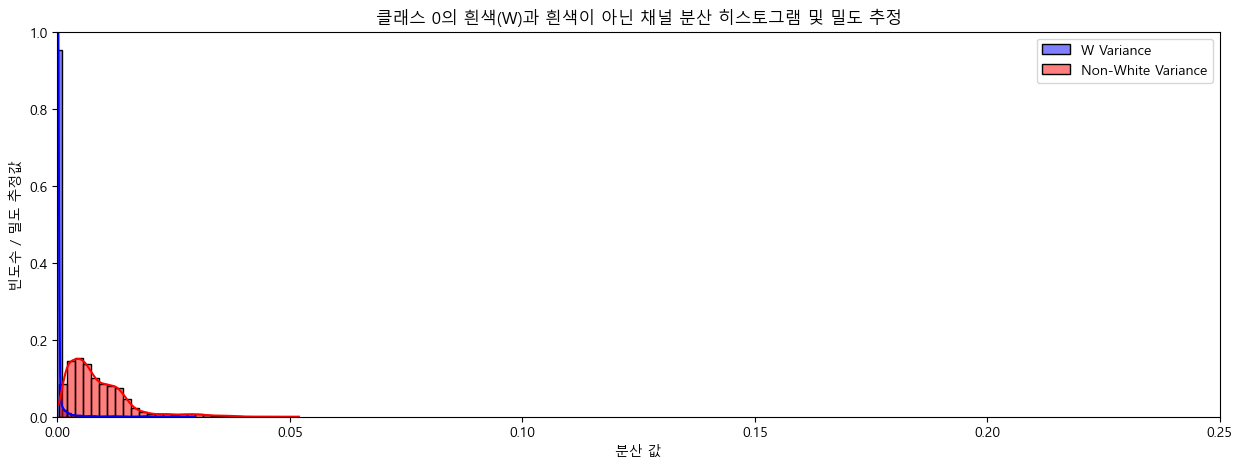

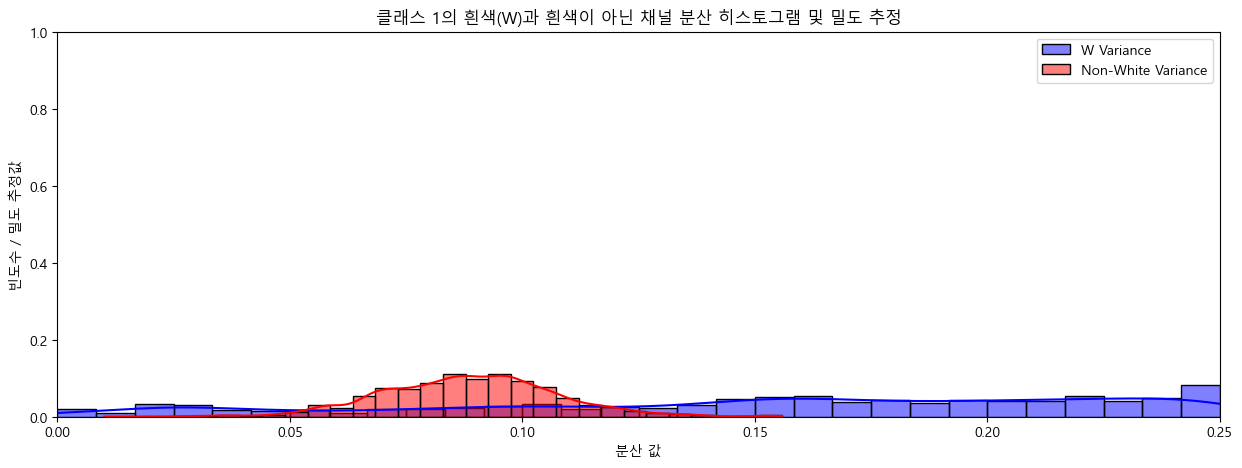

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import torchvision.transforms as transforms
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 및 통계적 실험과 유의성 검정 수행
def calculate_white_and_nonwhite(img_tensor):
    """
    RGB 텐서에서 흰색(W) 채널과 흰색이 아닌 나머지 채널을 계산합니다.
    흰색(W)은 모든 R, G, B 값이 균일하게 0.5를 초과하고, R, G, B 간 차이가 0.1 이하인 경우로 정의하고, 흰색이 아닌 것은 나머지 채널 값으로 정의합니다.
    
    Parameters:
        img_tensor (torch.Tensor): [3, H, W] 형태의 텐서 (RGB 이미지).
        
    Returns:
        torch.Tensor: [2, H, W] 형태의 텐서 (흰색, 흰색이 아닌 것).
    """
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    r_channel = img_array[0]
    g_channel = img_array[1]
    b_channel = img_array[2]
    
    # W (흰색) 채널을 계산: 모든 R, G, B 값이 0.5를 초과하고, R, G, B 간 차이가 0.1 이하인 경우
    w_channel = np.where((r_channel > 0.85) & (g_channel > 0.85) & (b_channel > 0.85), 1.0, 0.0)

    # 흰색이 아닌 나머지 값 계산
    non_white_channel = np.maximum.reduce([r_channel, g_channel, b_channel]) - w_channel

    # 새로운 텐서 생성
    white_nonwhite_tensor = np.stack([w_channel, non_white_channel], axis=0)  # [W, Non-White] 순서
    return torch.tensor(white_nonwhite_tensor)

def perform_statistical_experiments_and_tests(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터에서 흰색 및 흰색이 아닌 채널 평균 및 분산 추출
    label_data = {}
    observed_means = {}
    observed_variances = {}
    for label in np.unique(labels):
        label_items = [calculate_white_and_nonwhite(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        w_variances = [np.var(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_variances = [np.var(item.numpy()[1].flatten()) for item in label_items]
        
        label_data[label] = {'W': w_means, 'Non-White': nonwhite_means, 'W Variance': w_variances, 'Non-White Variance': nonwhite_variances}
        observed_means[label] = {'W': np.mean(w_means), 'Non-White': np.mean(nonwhite_means)}
        observed_variances[label] = {'W': np.mean(w_variances), 'Non-White': np.mean(nonwhite_variances)}
    
    # t-검정을 통한 클래스 간 유의성 검정
    for channel in ['W', 'Non-White']:
        t_stat, p_value = ttest_ind(label_data[0][channel], label_data[1][channel], equal_var=False)
        df = len(label_data[0][channel]) + len(label_data[1][channel]) - 2
        var_0 = np.var(label_data[0][channel], ddof=1)
        var_1 = np.var(label_data[1][channel], ddof=1)
        print(f"{channel} 채널의 클래스 간 t-검정 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}, 자유도 = {df}, 분산(음성) = {var_0:.4f}, 분산(양성) = {var_1:.4f}")
        if p_value < 0.05:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)")
        else:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의하지 않습니다. (p >= 0.05)")
    
    # 샘플 평균 및 표준 오차 계산
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            if 'Variance' not in channel:
                sample_mean = np.mean(means)
                sample_std_error = np.std(means) / np.sqrt(len(means))
                print(f"클래스 {label}의 {channel} 채널 샘플 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")
        
    # 신뢰 구간 계산 (95% 신뢰 구간)
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            if 'Variance' not in channel:
                sample_mean = np.mean(means)
                sample_std_error = np.std(means) / np.sqrt(len(means))
                ci_lower = sample_mean - 1.96 * sample_std_error
                ci_upper = sample_mean + 1.96 * sample_std_error
                print(f"클래스 {label}의 {channel} 채널 95% 신뢰 구간: ({ci_lower:.4f}, {ci_upper:.4f})")
    
    # 흰색과 흰색이 아닌 채널 간 평균 비교 (분산분석)
    for label in np.unique(labels):
        anova_data = []
        for i in range(len(label_data[label]['W'])):
            anova_data.append(['W', label_data[label]['W'][i], label])
            anova_data.append(['Non-White', label_data[label]['Non-White'][i], label])
        
        anova_df = pd.DataFrame(anova_data, columns=['Channel', 'Value', 'Label'])
        
        # 분산분석 수행
        model = smf.ols('Value ~ C(Channel)', data=anova_df).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)
        print(f"클래스 {label}의 분산분석 결과:", anova_results)
    
    # 분산 히스토그램 시각화
    for label in np.unique(labels):
        plt.figure(figsize=(15, 5))
        sns.histplot(label_data[label]['W Variance'], bins=30, color='blue', kde=True, label='W Variance', stat='probability')
        sns.histplot(label_data[label]['Non-White Variance'], bins=30, color='red', kde=True, label='Non-White Variance', stat='probability')
        plt.xlabel('분산 값')
        plt.xlim(0,0.25)
        plt.ylim(0,1)
        plt.ylabel('빈도수 / 밀도 추정값')
        plt.title(f'클래스 {label}의 흰색(W)과 흰색이 아닌 채널 분산 히스토그램 및 밀도 추정')
        plt.legend()
        plt.show()

# 통계적 실험과 유의성 검정 수행
perform_statistical_experiments_and_tests(dataset)





W 채널의 클래스 간 t-검정 결과: t-statistic = -149.4983, p-value = 0.0000e+00, 자유도 = 24140, 분산(음성) = 0.0000, 분산(양성) = 0.0167
W 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)
Non-White 채널의 클래스 간 t-검정 결과: t-statistic = 185.6338, p-value = 0.0000e+00, 자유도 = 24140, 분산(음성) = 0.0115, 분산(양성) = 0.0060
Non-White 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)
클래스 0의 W 채널 샘플 평균: 0.0003, 표준 오차: 0.0000
클래스 0의 Non-White 채널 샘플 평균: 0.5625, 표준 오차: 0.0008
클래스 1의 W 채널 샘플 평균: 0.2143, 표준 오차: 0.0014
클래스 1의 Non-White 채널 샘플 평균: 0.3385, 표준 오차: 0.0009
클래스 0의 W 채널 95% 신뢰 구간: (0.0002, 0.0003)
클래스 0의 Non-White 채널 95% 신뢰 구간: (0.5609, 0.5642)
클래스 1의 W 채널 95% 신뢰 구간: (0.2115, 0.2171)
클래스 1의 Non-White 채널 95% 신뢰 구간: (0.3368, 0.3401)
클래스 0의 분산분석 결과:                  sum_sq       df              F  PR(>F)
C(Channel)  2527.326431      1.0  439168.539243     0.0
Residual     184.003926  31974.0            NaN     NaN
클래스 1의 분산분석 결과:                 sum_sq       df            F  PR(>F)
C(Channel)   62.842515      1.0  5530.517827     0.0
Residual 

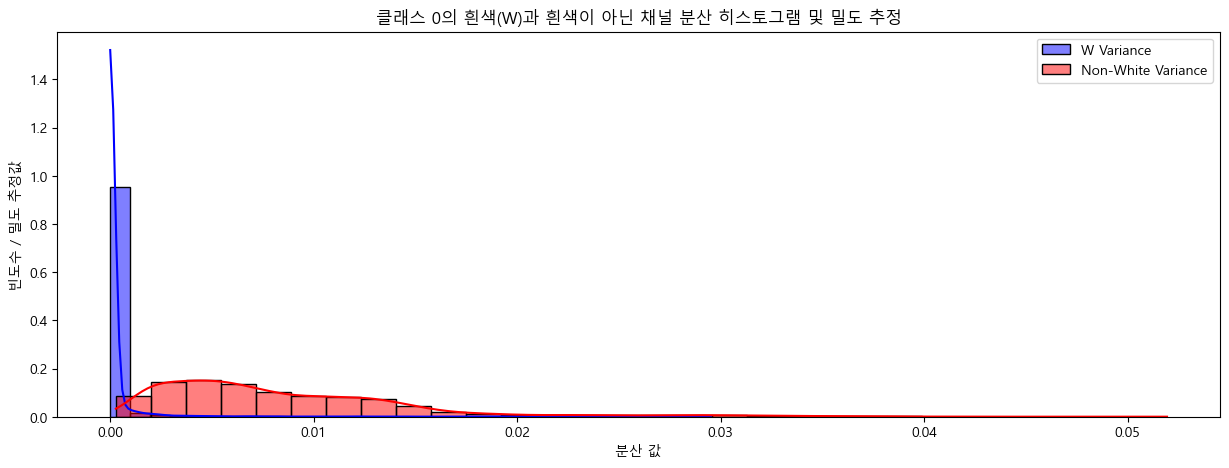

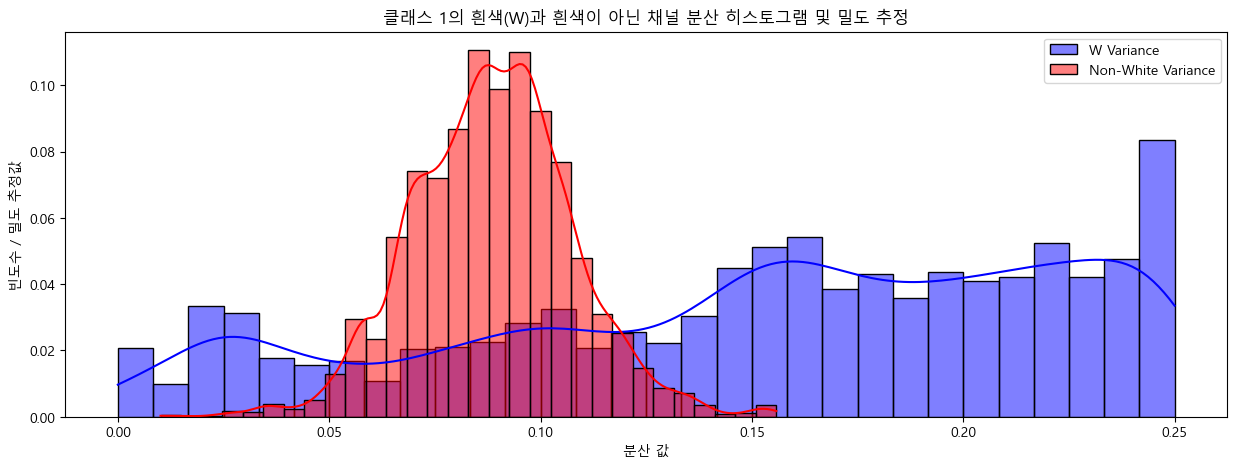

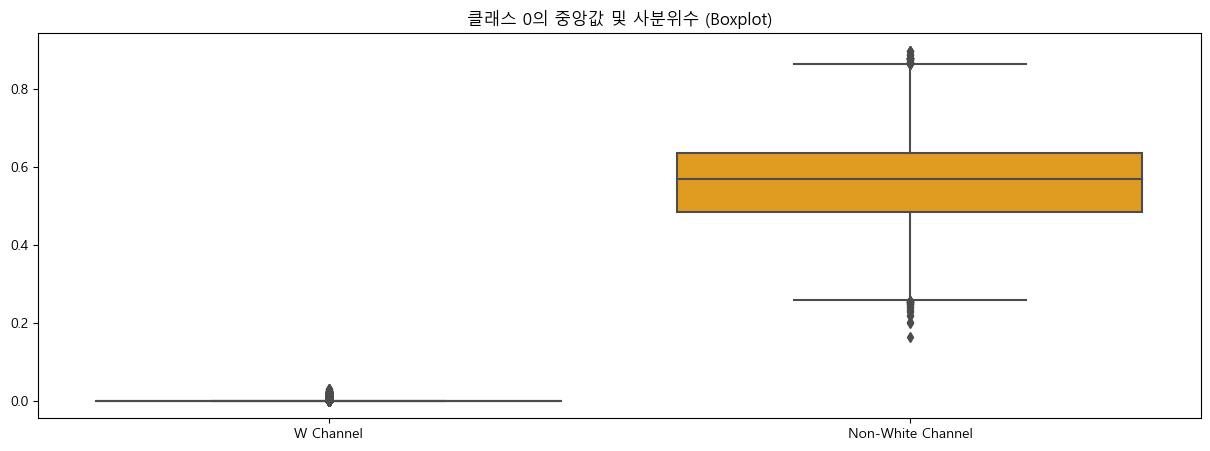

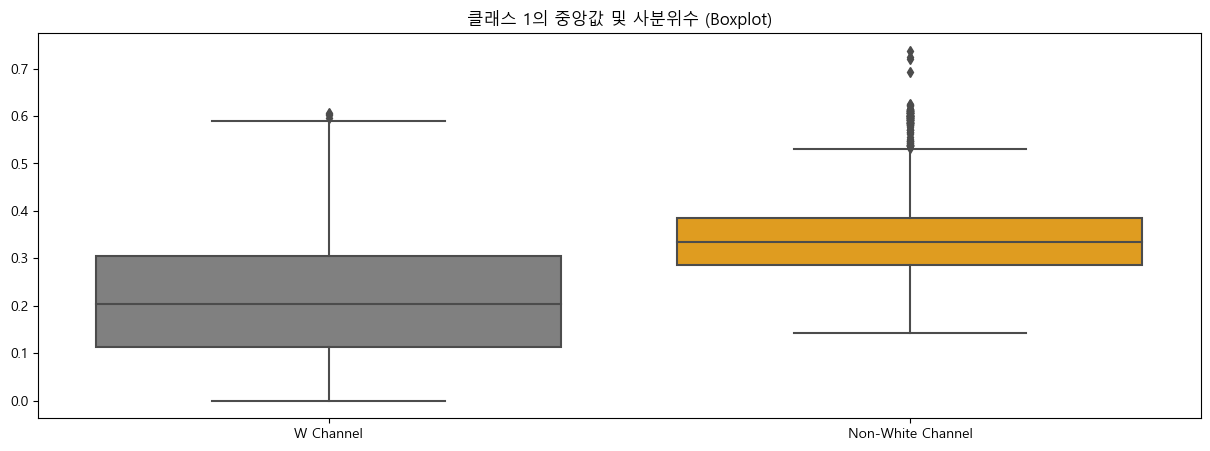

2024-11-10 06:04:20,768 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001D8D92F8148>


클래스 0의 흰색과 흰색이 아닌 채널 간 Pearson 상관계수: -0.0798
클래스 1의 흰색과 흰색이 아닌 채널 간 Pearson 상관계수: -0.7042


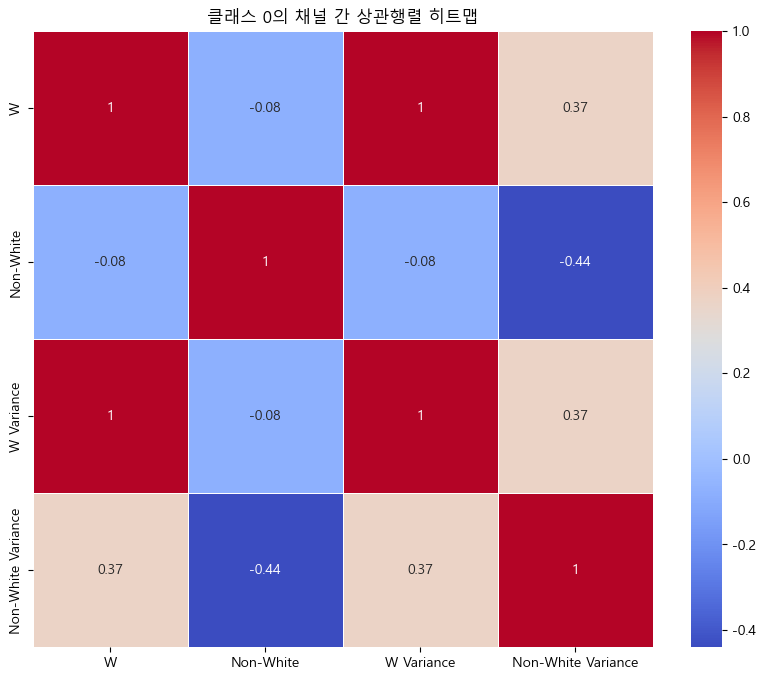

2024-11-10 06:04:21,003 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001D93F4ACC48>


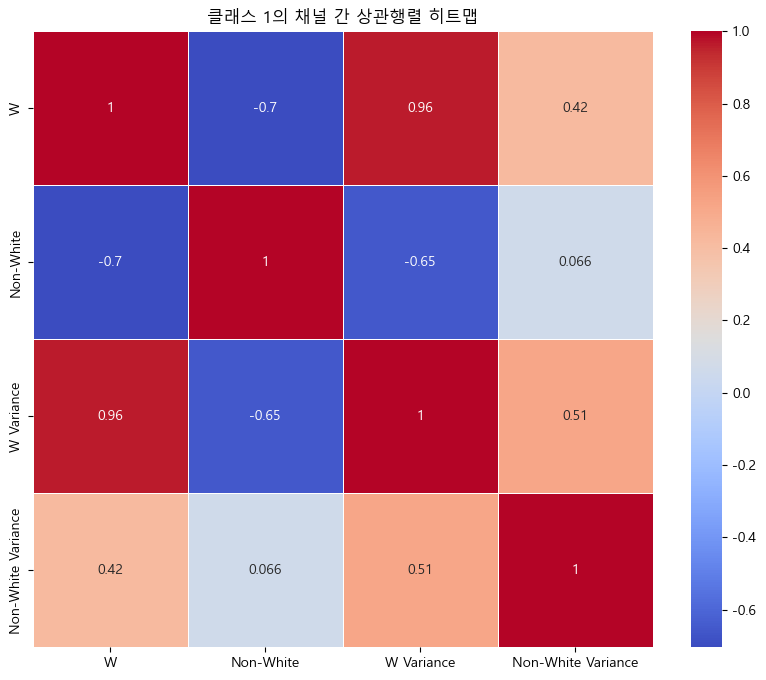

In [86]:

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 및 통계적 실험과 유의성 검정 수행
def calculate_white_and_nonwhite(img_tensor):
    """
    RGB 텐서에서 흰색(W) 채널과 흰색이 아닌 나머지 채널을 계산합니다.
    흰색(W)은 모든 R, G, B 값이 균일하게 0.5를 초과하고, R, G, B 간 차이가 0.1 이하인 경우로 정의하고, 흰색이 아닌 것은 나머지 채널 값으로 정의합니다.
    
    Parameters:
        img_tensor (torch.Tensor): [3, H, W] 형태의 텐서 (RGB 이미지).
        
    Returns:
        torch.Tensor: [2, H, W] 형태의 텐서 (흰색, 흰색이 아닌 것).
    """
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    r_channel = img_array[0]
    g_channel = img_array[1]
    b_channel = img_array[2]
    
    # W (흰색) 채널을 계산: 모든 R, G, B 값이 0.5를 초과하고, R, G, B 간 차이가 0.1 이하인 경우
    w_channel = np.where((r_channel > 0.85) & (g_channel > 0.85) & (b_channel > 0.85), 1.0, 0.0)

    # 흰색이 아닌 나머지 값 계산
    non_white_channel = np.maximum.reduce([r_channel, g_channel, b_channel]) - w_channel

    # 새로운 텐서 생성
    white_nonwhite_tensor = np.stack([w_channel, non_white_channel], axis=0)  # [W, Non-White] 순서
    return torch.tensor(white_nonwhite_tensor)

def perform_statistical_experiments_and_tests(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터에서 흰색 및 흰색이 아닌 채널 평균 및 분산 추출
    label_data = {}
    observed_means = {}
    observed_variances = {}
    for label in np.unique(labels):
        label_items = [calculate_white_and_nonwhite(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        w_variances = [np.var(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_variances = [np.var(item.numpy()[1].flatten()) for item in label_items]
        
        label_data[label] = {'W': w_means, 'Non-White': nonwhite_means, 'W Variance': w_variances, 'Non-White Variance': nonwhite_variances}
        observed_means[label] = {'W': np.mean(w_means), 'Non-White': np.mean(nonwhite_means)}
        observed_variances[label] = {'W': np.mean(w_variances), 'Non-White': np.mean(nonwhite_variances)}
    
    # t-검정을 통한 클래스 간 유의성 검정
    for channel in ['W', 'Non-White']:
        t_stat, p_value = ttest_ind(label_data[0][channel], label_data[1][channel], equal_var=False)
        df = len(label_data[0][channel]) + len(label_data[1][channel]) - 2
        var_0 = np.var(label_data[0][channel], ddof=1)
        var_1 = np.var(label_data[1][channel], ddof=1)
        print(f"{channel} 채널의 클래스 간 t-검정 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}, 자유도 = {df}, 분산(음성) = {var_0:.4f}, 분산(양성) = {var_1:.4f}")
        if p_value < 0.05:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)")
        else:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의하지 않습니다. (p >= 0.05)")
    
    # 샘플 평균 및 표준 오차 계산
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            if 'Variance' not in channel:
                sample_mean = np.mean(means)
                sample_std_error = np.std(means) / np.sqrt(len(means))
                print(f"클래스 {label}의 {channel} 채널 샘플 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")
        
    # 신뢰 구간 계산 (95% 신뢰 구간)
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            if 'Variance' not in channel:
                sample_mean = np.mean(means)
                sample_std_error = np.std(means) / np.sqrt(len(means))
                ci_lower = sample_mean - 1.96 * sample_std_error
                ci_upper = sample_mean + 1.96 * sample_std_error
                print(f"클래스 {label}의 {channel} 채널 95% 신뢰 구간: ({ci_lower:.4f}, {ci_upper:.4f})")
    
    # 흰색과 흰색이 아닌 채널 간 평균 비교 (분산분석)
    for label in np.unique(labels):
        anova_data = []
        for i in range(len(label_data[label]['W'])):
            anova_data.append(['W', label_data[label]['W'][i], label])
            anova_data.append(['Non-White', label_data[label]['Non-White'][i], label])
        
        anova_df = pd.DataFrame(anova_data, columns=['Channel', 'Value', 'Label'])
        
        # 분산분석 수행
        model = smf.ols('Value ~ C(Channel)', data=anova_df).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)
        print(f"클래스 {label}의 분산분석 결과:", anova_results)
    
    # 분산 히스토그램 시각화
    for label in np.unique(labels):
        plt.figure(figsize=(15, 5))
        sns.histplot(label_data[label]['W Variance'], bins=30, color='blue', kde=True, label='W Variance', stat='probability')
        sns.histplot(label_data[label]['Non-White Variance'], bins=30, color='red', kde=True, label='Non-White Variance', stat='probability')
        plt.xlabel('분산 값')
        plt.ylabel('빈도수 / 밀도 추정값')
        plt.title(f'클래스 {label}의 흰색(W)과 흰색이 아닌 채널 분산 히스토그램 및 밀도 추정')
        plt.legend()
        plt.show()
    
    # 중앙값 및 사분위수 분석 (Boxplot)
    for label in np.unique(labels):
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=[label_data[label]['W'], label_data[label]['Non-White']], palette=['gray', 'orange'])
        plt.xticks([0, 1], ['W Channel', 'Non-White Channel'])
        plt.title(f'클래스 {label}의 중앙값 및 사분위수 (Boxplot)')
        plt.show()

    # 채널 간 상관 분석 (Pearson 상관계수)
    for label in np.unique(labels):
        corr, _ = pearsonr(label_data[label]['W'], label_data[label]['Non-White'])
        print(f"클래스 {label}의 흰색과 흰색이 아닌 채널 간 Pearson 상관계수: {corr:.4f}")
        
    # 히트맵과 상관행렬
    for label in np.unique(labels):
        data = pd.DataFrame(label_data[label])
        corr_matrix = data.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'클래스 {label}의 채널 간 상관행렬 히트맵')
        plt.show()

# 통계적 실험과 유의성 검정 수행
perform_statistical_experiments_and_tests(dataset)


2024-11-10 09:13:13,615 - matplotlib - DEBUG - matplotlib data path: c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\matplotlib\mpl-data
2024-11-10 09:13:13,676 - matplotlib - DEBUG - CONFIGDIR=C:\Users\1\.matplotlib
2024-11-10 09:13:13,686 - matplotlib - DEBUG - interactive is False
2024-11-10 09:13:13,688 - matplotlib - DEBUG - platform is win32
2024-11-10 09:13:13,758 - matplotlib - DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'nt', 'winreg', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', 'site', 'os', 'stat', '_stat', '_collections_abc', 'ntpath', 'genericpath', 'os.path', '_sitebuiltins', '_bootlocale', '_locale', '_distutils_hack', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'i

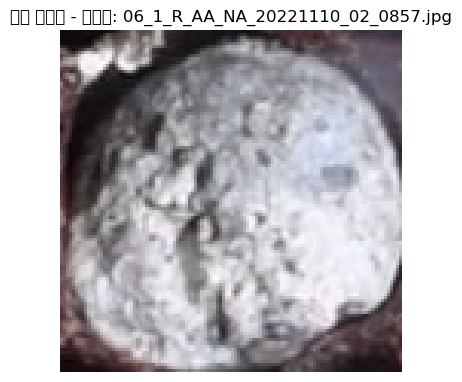

c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 55152 (\N{HANGUL SYLLABLE HYIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current 

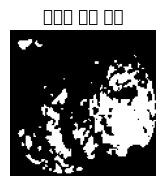

c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.

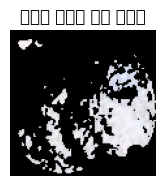

c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\1\anaconda3\envs\new_env_name\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45772 (\N{HANGUL SYLLABLE NIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


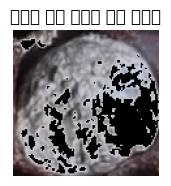

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms

# 임의의 이미지 한 개를 선택하고 흰색 채널을 조사

def calculate_white_channel(img_tensor):
    """
    RGB 텐서에서 흰색(W) 채널을 계산합니다.
    흰색(W)은 모든 R, G, B 값이 0.9를 초과하는 경우로 정의합니다.

    Parameters:
        img_tensor (torch.Tensor): [3, H, W] 형태의 RGB 텐서.

    Returns:
        numpy.ndarray: 흰색 채널로 계산된 2D 배열.
    """
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    r_channel = img_array[0]
    g_channel = img_array[1]
    b_channel = img_array[2]
    
    # W (흰색) 채널을 계산: 모든 R, G, B 값이 0.9를 초과하는 경우
    w_channel = np.where((r_channel > 0.8) & (g_channel > 0.8) & (b_channel > 0.8), 1.0, 0.0)
    return w_channel

def verify_white_channel(dataset):
    # 임의의 이미지 한 개 선택
    sampled_item = random.choice(dataset)
    img_tensor, label, filename = sampled_item
    
    # 흰색 채널 계산
    w_channel = calculate_white_channel(img_tensor)
    
    # 원본 이미지와 흰색 채널 시각화
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    plt.figure(figsize=(15, 15))
    
    # 원본 이미지
    plt.subplot(2, 3, 1)
    plt.imshow(np.transpose(img_array, (1, 2, 0)))
    plt.title(f'원본 이미지 - 파일명: {filename}')
    plt.axis('off')
    plt.show()
    # 흰색 채널 시각화
    plt.subplot(2, 3, 2)
    plt.imshow(w_channel, cmap='gray')
    plt.title('계산된 흰색 채널')
    plt.axis('off')
    plt.show()
    # 흰색인 부분만 남긴 이미지
    white_only_img = img_array * np.expand_dims(w_channel, axis=0)
    plt.subplot(2, 3, 4)
    plt.imshow(np.transpose(white_only_img, (1, 2, 0)))
    plt.title('흰색인 부분만 남긴 이미지')
    plt.axis('off')
    plt.show()
    # 흰색이 아닌 부분만 남긴 이미지
    non_white_channel = 1 - w_channel
    non_white_only_img = img_array * np.expand_dims(non_white_channel, axis=0)
    plt.subplot(2, 3, 5)
    plt.imshow(np.transpose(non_white_only_img, (1, 2, 0)))
    plt.title('흰색이 아닌 부분만 남긴 이미지')
    plt.axis('off')
    plt.show()
    
    

# 흰색 채널 조사 수행
verify_white_channel(dataset)





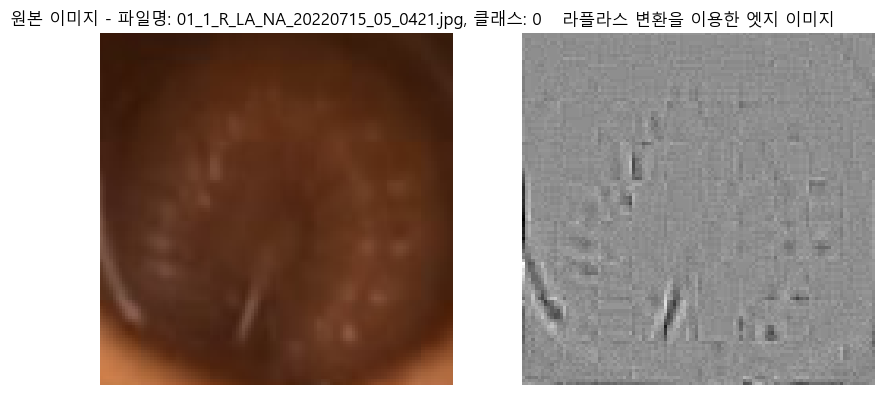

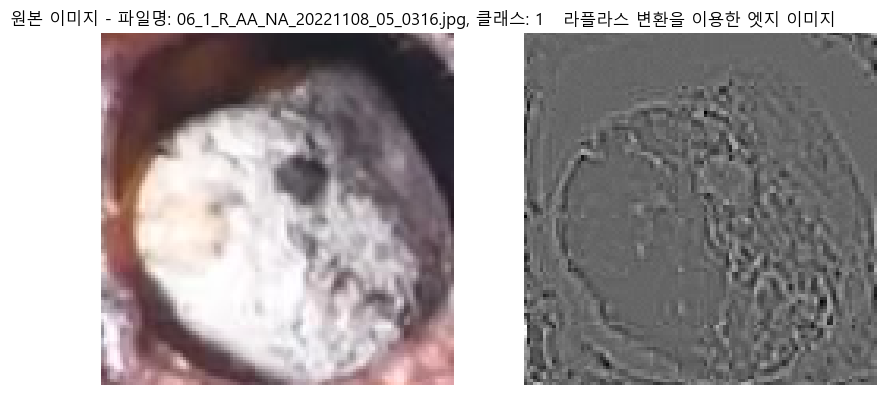

In [129]:
# 라플라스 변환과 엣지 분석 추가
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt


def laplacian_edge_analysis(dataset):
    
    for img_tensor, label, filename in dataset:
    # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_rgb = np.transpose(img_array, (1, 2, 0))  # [H, W, 3] 형태로 변환
    
    # 라플라스 변환을 사용한 엣지 검출
        img_gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)
    
# 클래스 0과 클래스 1에서 각각 한 개씩 이미지 선택
class_0_items = [item for item in dataset if item[1] == 0]
class_1_items = [item for item in dataset if item[1] == 1]
sampled_items = [random.choice(class_0_items), random.choice(class_1_items)]
for img_tensor, label, filename in [random.choice(class_0_items), random.choice(class_1_items)]:
    img_array = img_tensor.numpy()
    img_rgb = np.transpose(img_array, (1, 2, 0))  # [H, W, 3] 형태로 변환
    img_gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)
    # 원본 이미지와 엣지 이미지 시각화
    plt.figure(figsize=(10, 5))

    # 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f'원본 이미지 - 파일명: {filename}, 클래스: {label}')
    plt.axis('off')

    # 라플라스 엣지 이미지
    plt.subplot(1, 2, 2)
    plt.imshow(laplacian, cmap='gray')
    plt.title('라플라스 변환을 이용한 엣지 이미지')
    plt.axis('off')

    plt.show()
    
# 라플라스 변환과 엣지 분석 수행
laplacian_edge_analysis(dataset)




In [ ]:
# 공간 빈도 분석 (푸리에 변환)
# 푸리에 변환 결과를 이용한 히스토그램 생성 (여러 이미지)
def fourier_histogram_analysis(dataset):
    # 클래스별 주파수 성분의 크기를 모아서 히스토그램 생성
    all_frequencies_class_0 = []
    all_frequencies_class_1 = []

    # 클래스 0과 클래스 1의 주파수 성분을 모아서 리스트에 저장
    for img_tensor, label, filename in dataset:
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환

        # 푸리에 변환 수행
        f_transform = np.fft.fft2(img_gray)
        f_shift = np.fft.fftshift(f_transform)

        # 복소수 형태의 주파수 성분 크기를 계산 (진폭)
        magnitude_spectrum = np.abs(f_shift)

        # 주파수 성분 크기를 클래스별로 저장
        if label == 0:
            all_frequencies_class_0.extend(magnitude_spectrum.ravel())
        elif label == 1:
            all_frequencies_class_1.extend(magnitude_spectrum.ravel())

    # 클래스별 히스토그램 시각화
    plt.figure(figsize=(15, 5))

    # 클래스 0의 주파수 성분 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(all_frequencies_class_0, bins=256, color='blue', alpha=0.7)
    plt.title('클래스 0의 주파수 성분 히스토그램')
    plt.xlabel('주파수 성분 크기')
    plt.ylabel('빈도수')

    # 클래스 1의 주파수 성분 히스토그램
    plt.subplot(1, 2, 2)
    plt.hist(all_frequencies_class_1, bins=256, color='red', alpha=0.7)
    plt.title('클래스 1의 주파수 성분 히스토그램')
    plt.xlabel('주파수 성분 크기')
    plt.ylabel('빈도수')

    plt.tight_layout()
    plt.show()


    class_0_items = [item for item in dataset if item[1] == 0]
    class_1_items = [item for item in dataset if item[1] == 1]
    sampled_items = [random.choice(class_0_items), random.choice(class_1_items)]
    for img_tensor, label, filename in [random.choice(class_0_items), random.choice(class_1_items)]:    
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환
        
        # 푸리에 변환 수행
        f_transform = np.fft.fft2(img_gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)  # 로그 스케일로 시각화
        # 원본 이미지와 푸리에 변환 결과 
        plt.figure(figsize=(10, 5))
        
        # 원본 이미지 (그레이스케일)
        plt.subplot(1, 2, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'원본 이미지 (그레이스케일) - 파일명: {filename}, 클래스: {label}')
        plt.axis('off')
        
        # 푸리에 변환 결과
        plt.subplot(1, 2, 2)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('푸리에 변환을 이용한 공간 빈도 분석')
        plt.axis('off')
        
        plt.show()

# 공간 빈도 분석 수행
fourier_histogram_analysis(dataset)

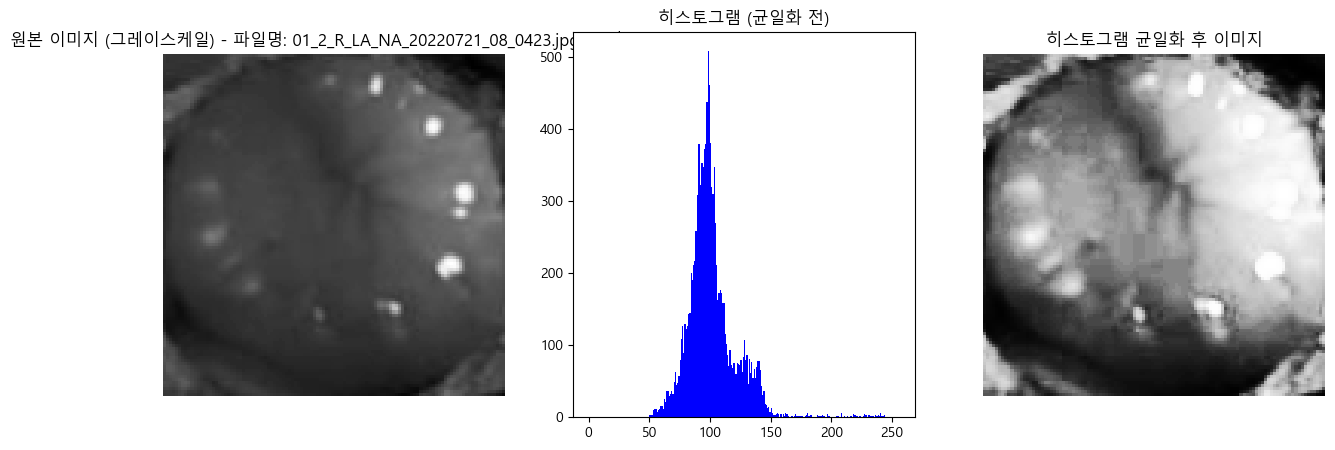

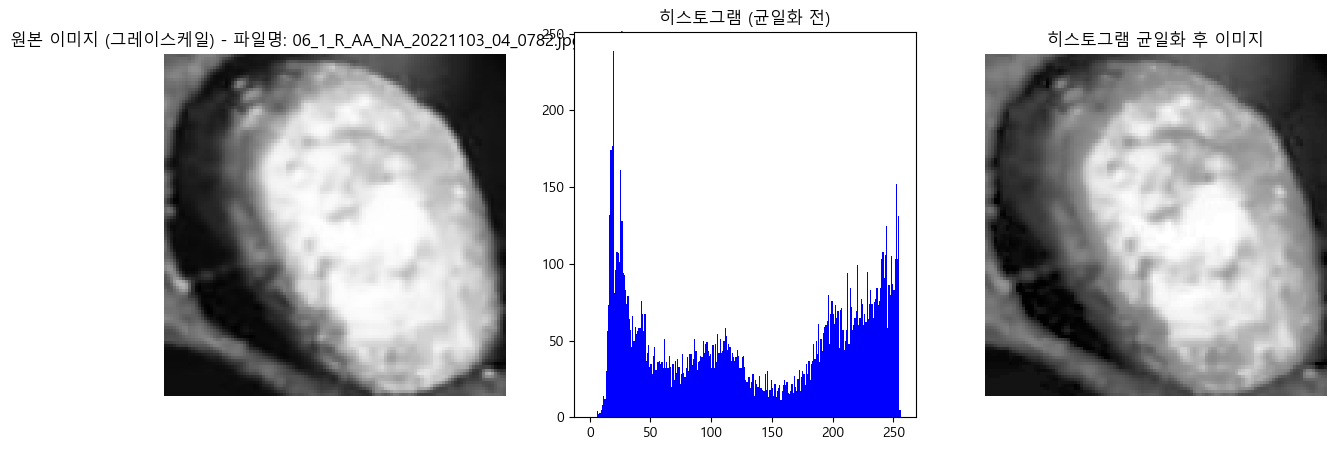

In [133]:
def histogram_equalization_analysis(dataset):
    # 클래스 0과 클래스 1에서 각각 한 개씩 이미지 선택
    class_0_items = [item for item in dataset if item[1] == 0]
    class_1_items = [item for item in dataset if item[1] == 1]
    sampled_items = [random.choice(class_0_items), random.choice(class_1_items)]
    
    for img_tensor, label, filename in dataset:
        
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환
        img_gray_uint8 = (img_gray * 255).astype(np.uint8)
        
        # 히스토그램 균일화 수행
        equalized_img = cv2.equalizeHist(img_gray_uint8) / 255.0
    for img_tensor, label, filename in [random.choice(class_0_items), random.choice(class_1_items)]:
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환
        img_gray_uint8 = (img_gray * 255).astype(np.uint8)
        
        # 히스토그램 균일화 수행
        equalized_img = cv2.equalizeHist(img_gray_uint8) / 255.0      
        # 원본 이미지와 히스토그램 균일화 이미지 시각화
        plt.figure(figsize=(15, 5))
        
        # 원본 이미지 (그레이스케일)
        plt.subplot(1, 3, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'원본 이미지 (그레이스케일) - 파일명: {filename}, 클래스: {label}')
        plt.axis('off')
        
        # 히스토그램 균일화 전 히스토그램
        plt.subplot(1, 3, 2)
        plt.hist(img_gray_uint8.ravel(), 256, [0, 256], color='blue')
        plt.title('히스토그램 (균일화 전)')
        
        # 히스토그램 균일화 후 이미지
        plt.subplot(1, 3, 3)
        plt.imshow(equalized_img, cmap='gray')
        plt.title('히스토그램 균일화 후 이미지')
        plt.axis('off')
        
        plt.show()

# 히스토그램 균일화 전후 분석 수행
histogram_equalization_analysis(dataset)

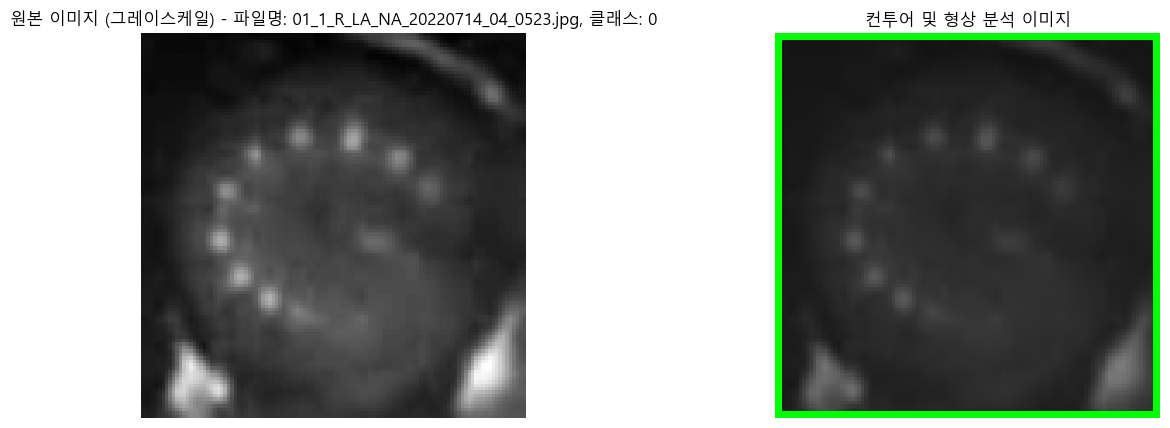

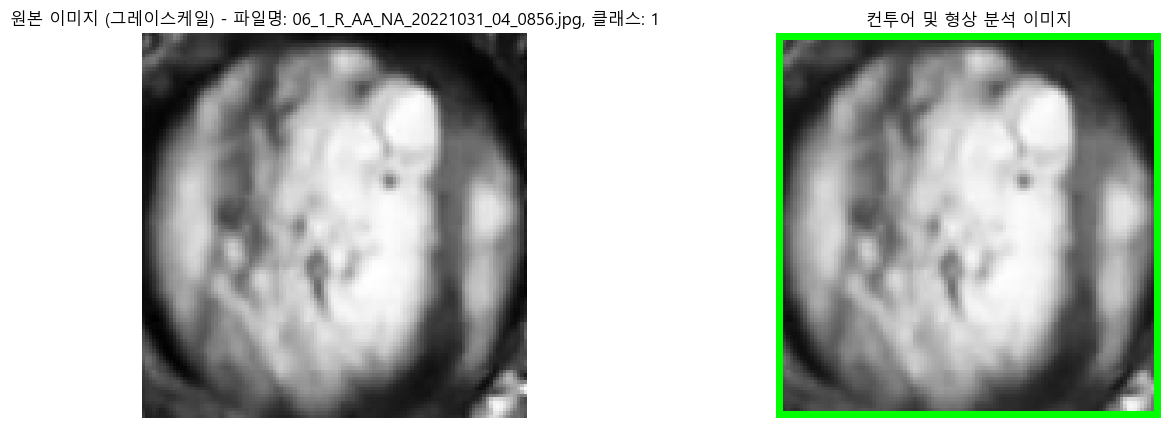

In [139]:
# 컨투어 및 형상 분석
def contour_and_shape_analysis(dataset):
    for img_tensor, label, filename in dataset:
       # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환
        img_gray_uint8 = (img_gray * 255).astype(np.uint8)
        
        # 컨투어 검출
        contours, _ = cv2.findContours(img_gray_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    # 클래스 0과 클래스 1에서 각각 한 개씩 이미지 선택
    class_0_items = [item for item in dataset if item[1] == 0]
    class_1_items = [item for item in dataset if item[1] == 1]
    sampled_items = [random.choice(class_0_items), random.choice(class_1_items)]
    for sampled_item in sampled_items:
        img_tensor, label, filename = sampled_item
        
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환
        img_gray_uint8 = (img_gray * 255).astype(np.uint8)
        
        # 컨투어 검출
        contours, _ = cv2.findContours(img_gray_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 원본 이미지와 컨투어 이미지 시각화
        img_contour = cv2.cvtColor(img_gray_uint8, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_contour, contours, -1, (0, 255, 0), 2)
        
        plt.figure(figsize=(15, 5))
        
        # 원본 이미지 (그레이스케일)
        plt.subplot(1, 2, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'원본 이미지 (그레이스케일) - 파일명: {filename}, 클래스: {label}')
        plt.axis('off')
        
        # 컨투어 이미지
        plt.subplot(1, 2, 2)
        plt.imshow(img_contour)
        plt.title('컨투어 및 형상 분석 이미지')
        plt.axis('off')
        
        plt.show()

# 컨투어 및 형상 분석 수행
contour_and_shape_analysis(dataset)

파일명: 01_2_R_LA_NA_20220721_06_0812.jpg, 클래스: 0
H 채널 평균: 10.43
S 채널 평균: 221.72
V 채널 평균: 75.43
파일명: 01_1_R_LA_NA_20220714_02_1203.jpg, 클래스: 0
H 채널 평균: 9.85
S 채널 평균: 179.44
V 채널 평균: 116.49
파일명: 01_1_R_LA_NA_20220707_03_309.jpg, 클래스: 0
H 채널 평균: 9.32
S 채널 평균: 152.57
V 채널 평균: 108.57
파일명: 01_2_R_LA_NA_20220722_03_0238.jpg, 클래스: 0
H 채널 평균: 13.95
S 채널 평균: 193.80
V 채널 평균: 149.18
파일명: 01_1_R_LA_NA_20220715_03_0465.jpg, 클래스: 0
H 채널 평균: 10.45
S 채널 평균: 174.10
V 채널 평균: 133.82
파일명: 01_1_R_LA_NA_20220715_01_0313.jpg, 클래스: 0
H 채널 평균: 9.45
S 채널 평균: 154.68
V 채널 평균: 109.19
파일명: 01_1_R_LA_NA_20220714_09_0284.jpg, 클래스: 0
H 채널 평균: 10.84
S 채널 평균: 151.10
V 채널 평균: 142.06
파일명: 01_1_R_LA_NA_20220714_04_0077.jpg, 클래스: 0
H 채널 평균: 10.04
S 채널 평균: 178.35
V 채널 평균: 99.34
파일명: 01_2_R_LA_NA_20220722_02_0863.jpg, 클래스: 0
H 채널 평균: 13.67
S 채널 평균: 183.66
V 채널 평균: 182.27
파일명: 01_1_R_LA_NA_20220714_02_0424.jpg, 클래스: 0
H 채널 평균: 10.20
S 채널 평균: 159.59
V 채널 평균: 137.54
파일명: 01_2_R_LA_NA_20220721_09_0575.jpg, 클래스: 0
H 채널 평균: 10.58
S 채널

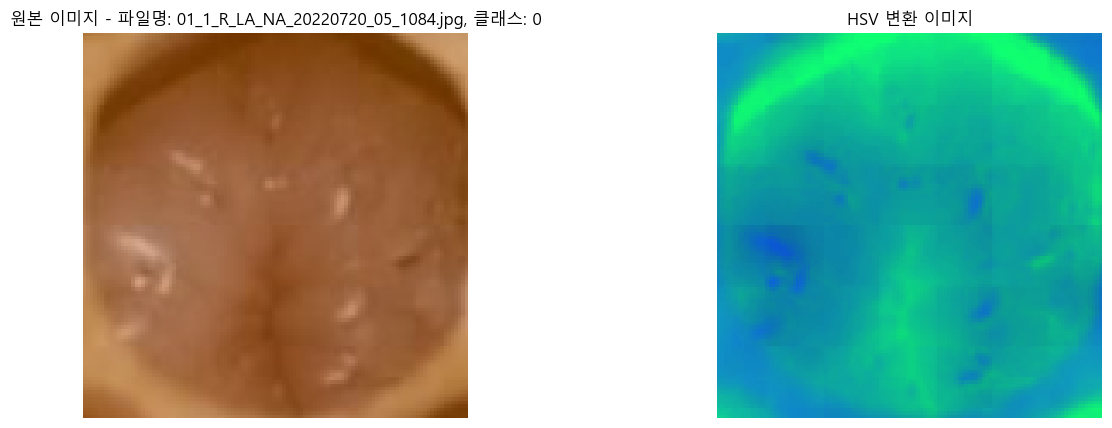

파일명: 06_1_R_AA_NA_20221109_01_1082.jpg, 클래스: 1
H 채널 평균: 14.81
S 채널 평균: 118.90
V 채널 평균: 144.81


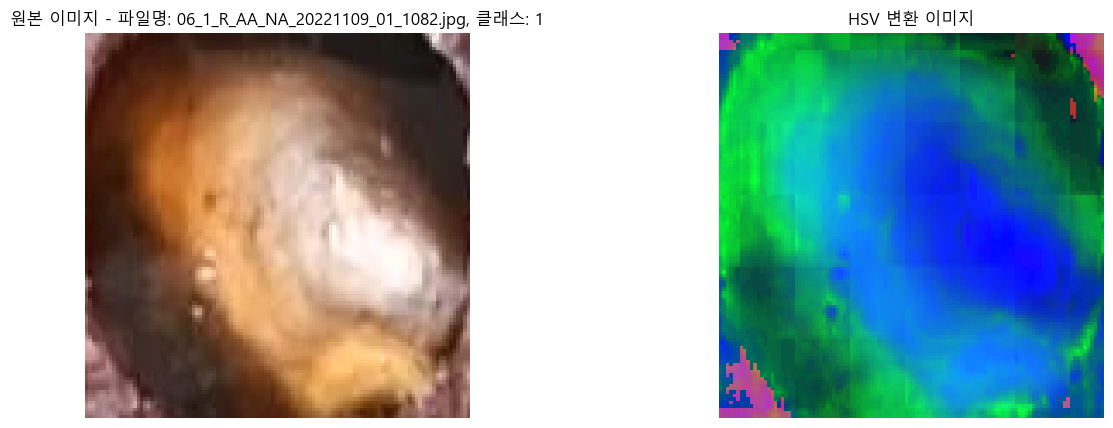

In [140]:
# 색상 비율 분석 (HSV 변환)
def hsv_color_ratio_analysis(dataset):
    for img_tensor, label, filename in dataset:
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_rgb = np.transpose(img_array, (1, 2, 0))  # [H, W, 3] 형태로 변환
        
        # RGB 이미지를 HSV로 변환
        img_hsv = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        
        # HSV 채널 분리 및 평균 계산
        h_mean = np.mean(img_hsv[:, :, 0])
        s_mean = np.mean(img_hsv[:, :, 1])
        v_mean = np.mean(img_hsv[:, :, 2])
        
        # 색상 비율 분석 결과 출력
        print(f'파일명: {filename}, 클래스: {label}')
        print(f'H 채널 평균: {h_mean:.2f}')
        print(f'S 채널 평균: {s_mean:.2f}')
        print(f'V 채널 평균: {v_mean:.2f}')

    # 클래스 0과 클래스 1에서 각각 한 개씩 이미지 선택
    class_0_items = [item for item in dataset if item[1] == 0]
    class_1_items = [item for item in dataset if item[1] == 1]
    sampled_items = [random.choice(class_0_items), random.choice(class_1_items)]
    
    for sampled_item in sampled_items:
        img_tensor, label, filename = sampled_item
        
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_rgb = np.transpose(img_array, (1, 2, 0))  # [H, W, 3] 형태로 변환
        
        # RGB 이미지를 HSV로 변환
        img_hsv = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        
        # HSV 채널 분리 및 평균 계산
        h_mean = np.mean(img_hsv[:, :, 0])
        s_mean = np.mean(img_hsv[:, :, 1])
        v_mean = np.mean(img_hsv[:, :, 2])
        
        # 색상 비율 분석 결과 출력
        print(f'파일명: {filename}, 클래스: {label}')
        print(f'H 채널 평균: {h_mean:.2f}')
        print(f'S 채널 평균: {s_mean:.2f}')
        print(f'V 채널 평균: {v_mean:.2f}')
        
        # 원본 이미지와 HSV 이미지 시각화
        plt.figure(figsize=(15, 5))
        
        # 원본 이미지
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title(f'원본 이미지 - 파일명: {filename}, 클래스: {label}')
        plt.axis('off')
        
        # HSV 이미지
        plt.subplot(1, 2, 2)
        plt.imshow(img_hsv, cmap='hsv')
        plt.title('HSV 변환 이미지')
        plt.axis('off')
        
        plt.show()

# 색상 비율 분석 수행
hsv_color_ratio_analysis(dataset)


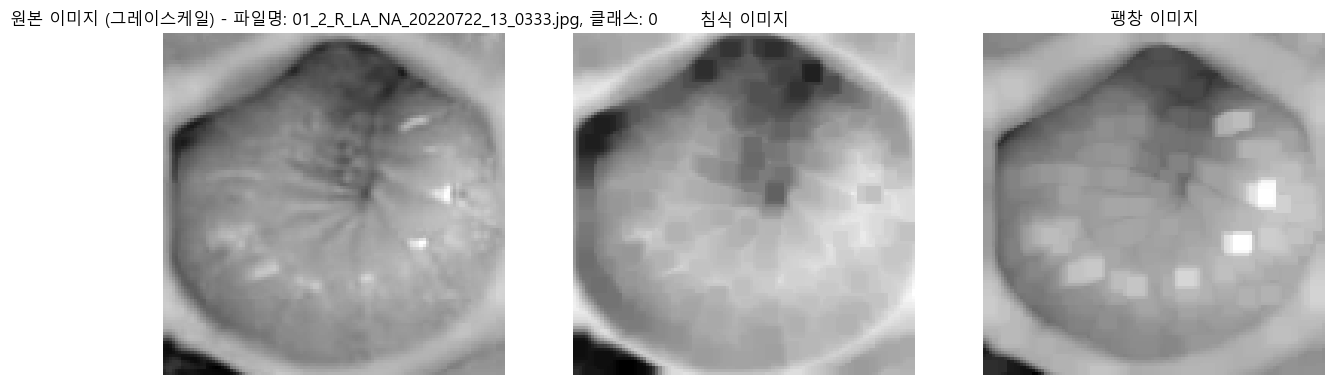

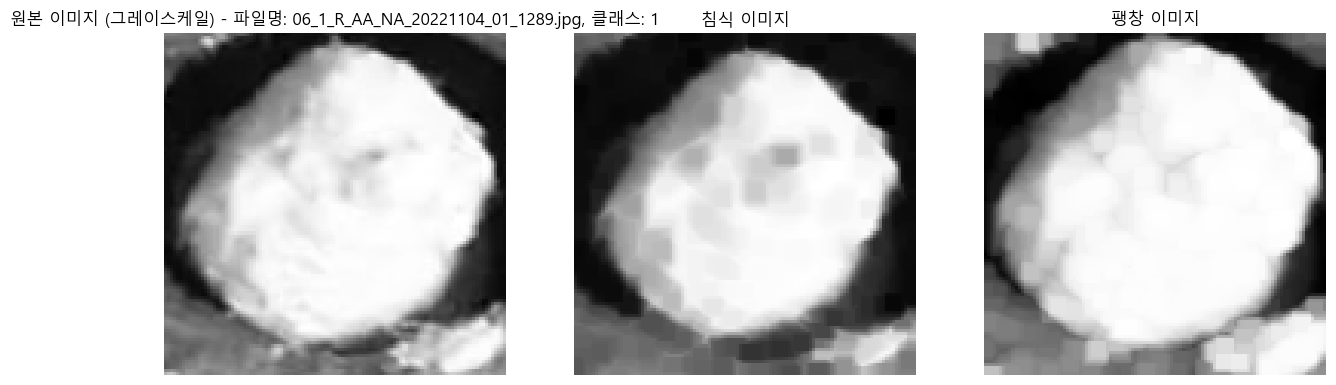

In [121]:
# 모폴로지 변환 분석
def morphology_analysis(dataset):
    # 클래스 0과 클래스 1에서 각각 한 개씩 이미지 선택
    class_0_items = [item for item in dataset if item[1] == 0]
    class_1_items = [item for item in dataset if item[1] == 1]
    sampled_items = [random.choice(class_0_items), random.choice(class_1_items)]
    
    for sampled_item in sampled_items:
        img_tensor, label, filename = sampled_item
        
        # 이미지를 numpy 배열로 변환
        img_array = img_tensor.numpy()
        img_gray = np.mean(img_array, axis=0)  # RGB 이미지를 그레이스케일로 변환
        img_gray_uint8 = (img_gray * 255).astype(np.uint8)
        
        # 모폴로지 변환 (침식 및 팽창)
        kernel = np.ones((5, 5), np.uint8)
        erosion = cv2.erode(img_gray_uint8, kernel, iterations=1)
        dilation = cv2.dilate(img_gray_uint8, kernel, iterations=1)
        
        # 원본 이미지와 모폴로지 변환 이미지 시각화
        plt.figure(figsize=(15, 10))
        
        # 원본 이미지 (그레이스케일)
        plt.subplot(1, 3, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'원본 이미지 (그레이스케일) - 파일명: {filename}, 클래스: {label}')
        plt.axis('off')
        
        # 침식 이미지
        plt.subplot(1, 3, 2)
        plt.imshow(erosion, cmap='gray')
        plt.title('침식 이미지')
        plt.axis('off')
        
        # 팽창 이미지
        plt.subplot(1, 3, 3)
        plt.imshow(dilation, cmap='gray')
        plt.title('팽창 이미지')
        plt.axis('off')
        
        plt.show()

# 모폴로지 변환 분석 수행
morphology_analysis(dataset)

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import torchvision.transforms as transforms
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 및 통계적 실험과 유의성 검정 수행
def calculate_white_and_nonwhite(img_tensor):
    """
    RGB 텐서에서 흰색(W) 채널과 흰색이 아닌 나머지 채널을 계산합니다.
    흰색(W)은 R, G, B 평균으로 정의하고, 흰색이 아닌 것은 나머지 채널 값으로 정의합니다.
    
    Parameters:
        img_tensor (torch.Tensor): [3, H, W] 형태의 텐서 (RGB 이미지).
        
    Returns:
        torch.Tensor: [2, H, W] 형태의 텐서 (흰색, 흰색이 아닌 것).
    """
    img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
    r_channel = img_array[0]
    g_channel = img_array[1]
    b_channel = img_array[2]
    
    # W (흰색) 채널을 계산: R, G, B 평균
    w_channel = (r_channel + g_channel + b_channel) / 3.0

    # 흰색이 아닌 나머지 값 계산
    non_white_channel = np.maximum.reduce([r_channel, g_channel, b_channel]) - w_channel

    # 새로운 텐서 생성
    white_nonwhite_tensor = np.stack([w_channel, non_white_channel], axis=0)  # [W, Non-White] 순서
    return torch.tensor(white_nonwhite_tensor)

def perform_statistical_experiments_and_tests(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터에서 흰색 및 흰색이 아닌 채널 평균 및 분산 추출
    label_data = {}
    observed_means = {}
    observed_variances = {}
    for label in np.unique(labels):
        label_items = [calculate_white_and_nonwhite(item[0]) for item in dataset if item[1] == label]
        w_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        w_variances = [np.var(item.numpy()[0].flatten()) for item in label_items]
        nonwhite_variances = [np.var(item.numpy()[1].flatten()) for item in label_items]
        
        label_data[label] = {'W': w_means, 'Non-White': nonwhite_means}
        observed_means[label] = {'W': np.mean(w_means), 'Non-White': np.mean(nonwhite_means)}
        observed_variances[label] = {'W': np.mean(w_variances), 'Non-White': np.mean(nonwhite_variances)}
    
    # t-검정을 통한 클래스 간 유의성 검정
    for channel in ['W', 'Non-White']:
        t_stat, p_value = ttest_ind(label_data[0][channel], label_data[1][channel], equal_var=False)
        df = len(label_data[0][channel]) + len(label_data[1][channel]) - 2
        var_0 = np.var(label_data[0][channel], ddof=1)
        var_1 = np.var(label_data[1][channel], ddof=1)
        print(f"{channel} 채널의 클래스 간 t-검정 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}, 자유도 = {df}, 분산(음성) = {var_0:.4f}, 분산(양성) = {var_1:.4f}")
        if p_value < 0.05:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)")
        else:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의하지 않습니다. (p >= 0.05)")
    
    # 샘플 평균 및 표준 오차 계산
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            print(f"클래스 {label}의 {channel} 채널 샘플 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")
        
    # 신뢰 구간 계산 (95% 신뢰 구간)
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            ci_lower = sample_mean - 1.96 * sample_std_error
            ci_upper = sample_mean + 1.96 * sample_std_error
            print(f"클래스 {label}의 {channel} 채널 95% 신뢰 구간: ({ci_lower:.4f}, {ci_upper:.4f})")
    
    # 흰색과 흰색이 아닌 채널 간 평균 비교 (분산분석)
    for label in np.unique(labels):
        anova_data = []
        for i in range(len(label_data[label]['W'])):
            anova_data.append(['W', label_data[label]['W'][i], label])
            anova_data.append(['Non-White', label_data[label]['Non-White'][i], label])
        
        anova_df = pd.DataFrame(anova_data, columns=['Channel', 'Value', 'Label'])
        
        # 분산분석 수행
        model = smf.ols('Value ~ C(Channel)', data=anova_df).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)
        print(f"클래스 {label}의 분산분석 결과:", anova_results)

# 통계적 실험과 유의성 검정 수행
perform_statistical_experiments_and_tests(dataset)




RuntimeError: Boolean value of Tensor with more than one value is ambiguous

2024-11-09 06:57:04,806 - matplotlib.font_manager - DEBUG - findfont: Matching Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-11-09 06:57:04,806 - matplotlib.font_manager - DEBUG - findfont: Matching Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-11-09 06:57:04,806 - matplotlib.font_manager - DEBUG - findfont: Matching Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-11-09 06:57:04,809 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\1\\anaconda3\\envs\\new_env_name\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-11-09 06:57:04,809 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\1\\anaconda3\\envs\\new_env_name\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\

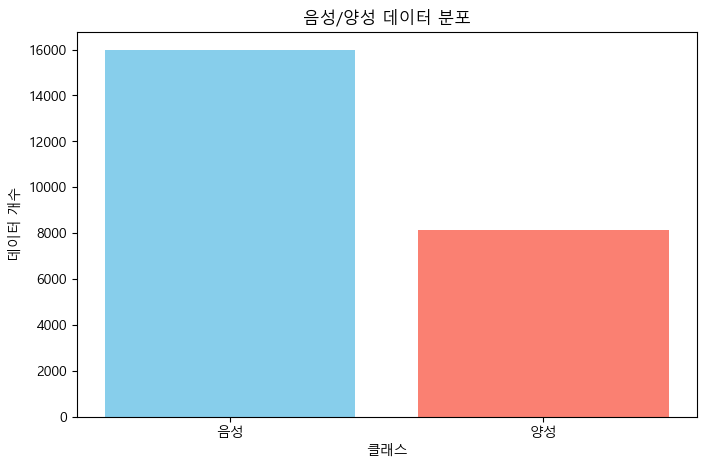

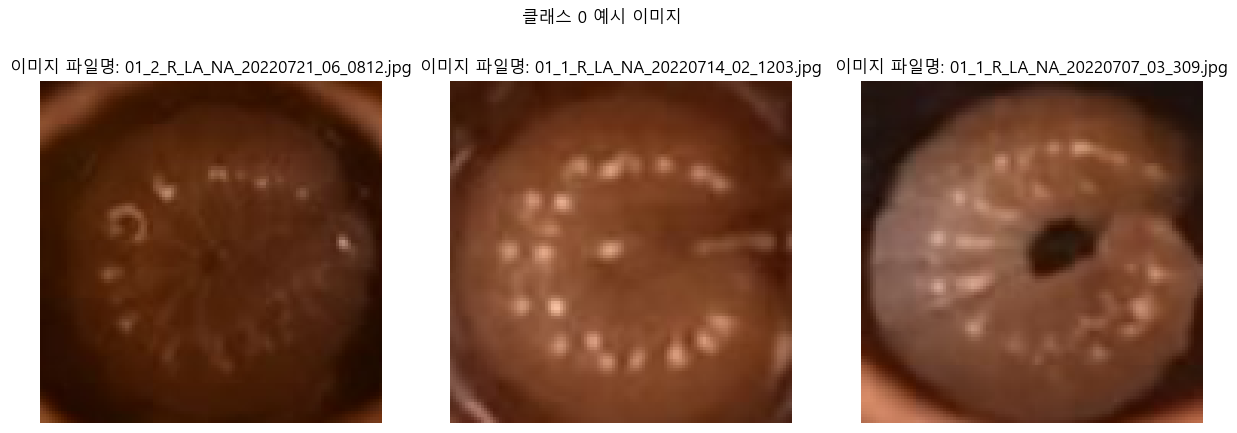

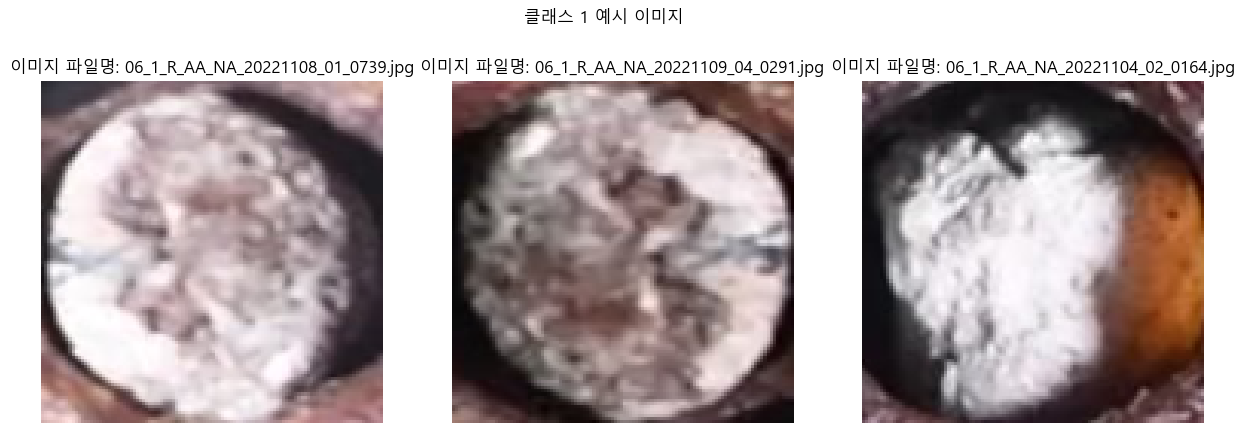


위치 추정 통계량 (RGB 채널별):
클래스 0: R 평균 = 0.5628, G 평균 = 0.3355, B 평균 = 0.1837
클래스 0: R 중앙값 = 0.5686, G 중앙값 = 0.3294, B 중앙값 = 0.1725
클래스 0: R 표준편차 = 0.0863, G 표준편차 = 0.0813, B 표준편차 = 0.0818
클래스 0: R 25번째 백분위수 = 0.5101, G 25번째 백분위수 = 0.2833, B 25번째 백분위수 = 0.1278
클래스 1: R 평균 = 0.5492, G 평균 = 0.5009, B 평균 = 0.5007
클래스 1: R 중앙값 = 0.5725, G 중앙값 = 0.4980, B 중앙값 = 0.4863
클래스 1: R 표준편차 = 0.2981, G 표준편차 = 0.3067, B 표준편차 = 0.3112
클래스 1: R 25번째 백분위수 = 0.2761, G 25번째 백분위수 = 0.2082, B 25번째 백분위수 = 0.2017


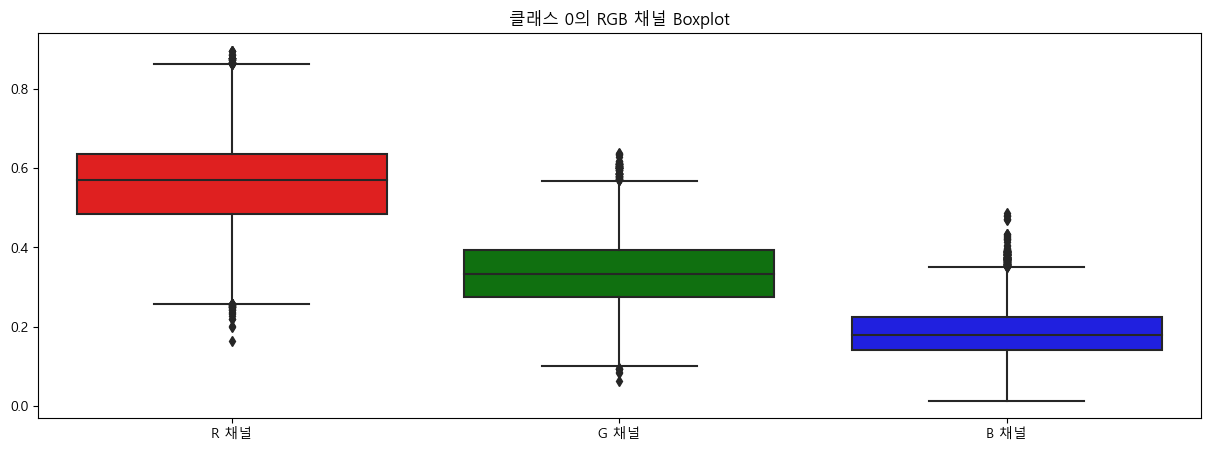

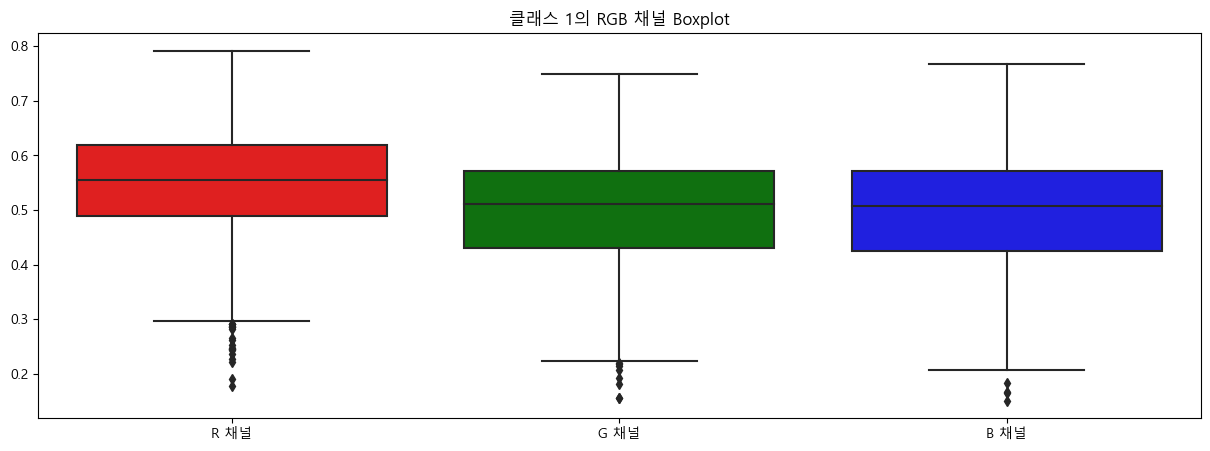

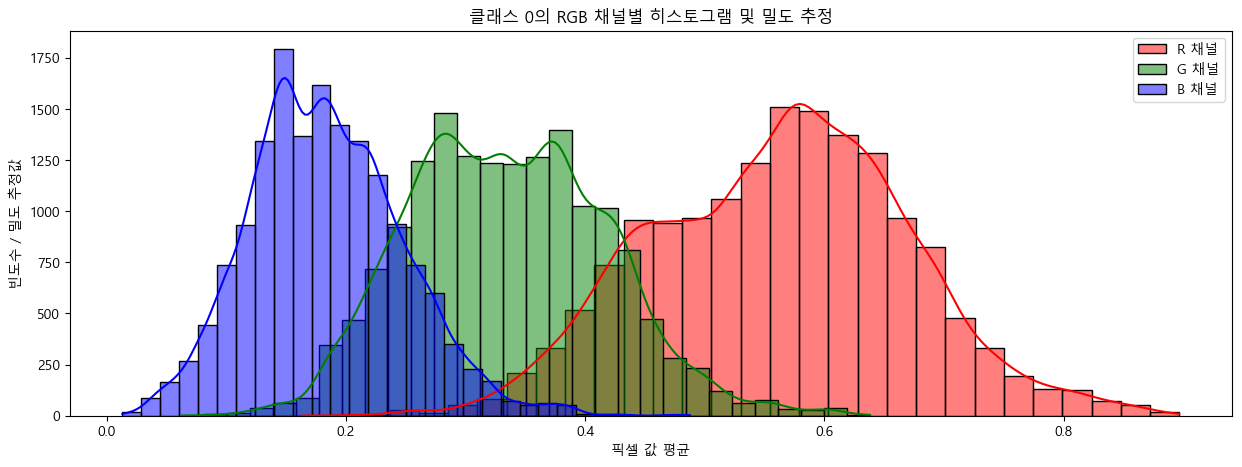

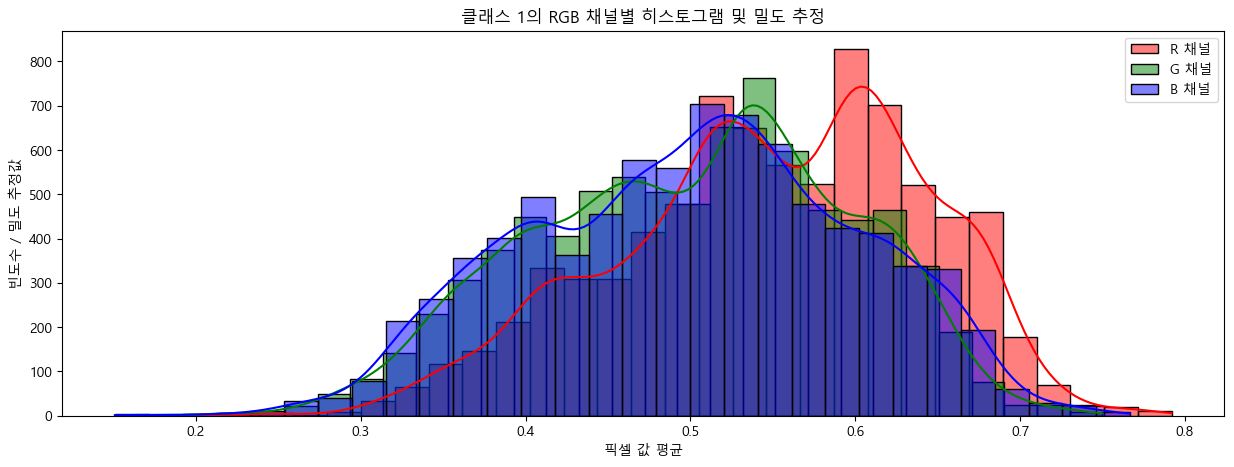

2024-11-09 06:57:41,120 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BFB2DBB48>
2024-11-09 06:57:41,120 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BFB2DBB48>
2024-11-09 06:57:41,120 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BFB2DBB48>


클래스 0의 RGB 채널 간 상관계수:
          R 채널 평균   G 채널 평균   B 채널 평균
R 채널 평균  1.000000  0.948607  0.654932
G 채널 평균  0.948607  1.000000  0.803394
B 채널 평균  0.654932  0.803394  1.000000



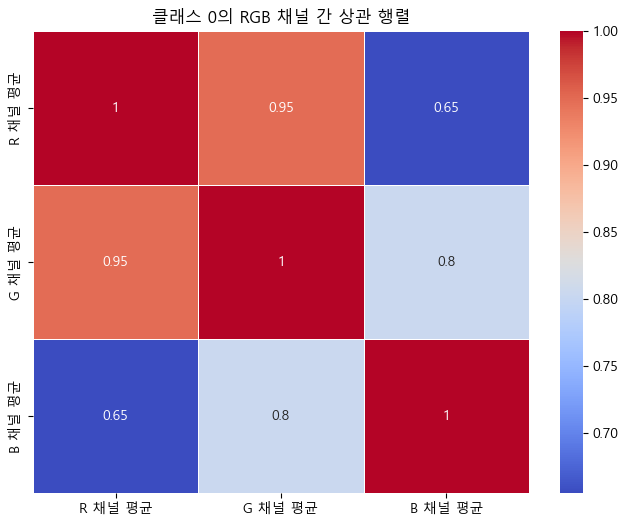

2024-11-09 06:57:42,170 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BF99D4508>
2024-11-09 06:57:42,170 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BF99D4508>
2024-11-09 06:57:42,170 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BF99D4508>


클래스 1의 RGB 채널 간 상관계수:
          R 채널 평균   G 채널 평균   B 채널 평균
R 채널 평균  1.000000  0.968490  0.914707
G 채널 평균  0.968490  1.000000  0.978675
B 채널 평균  0.914707  0.978675  1.000000



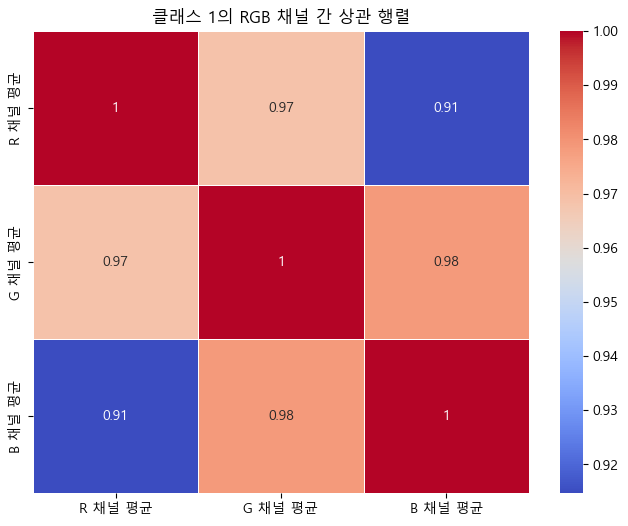

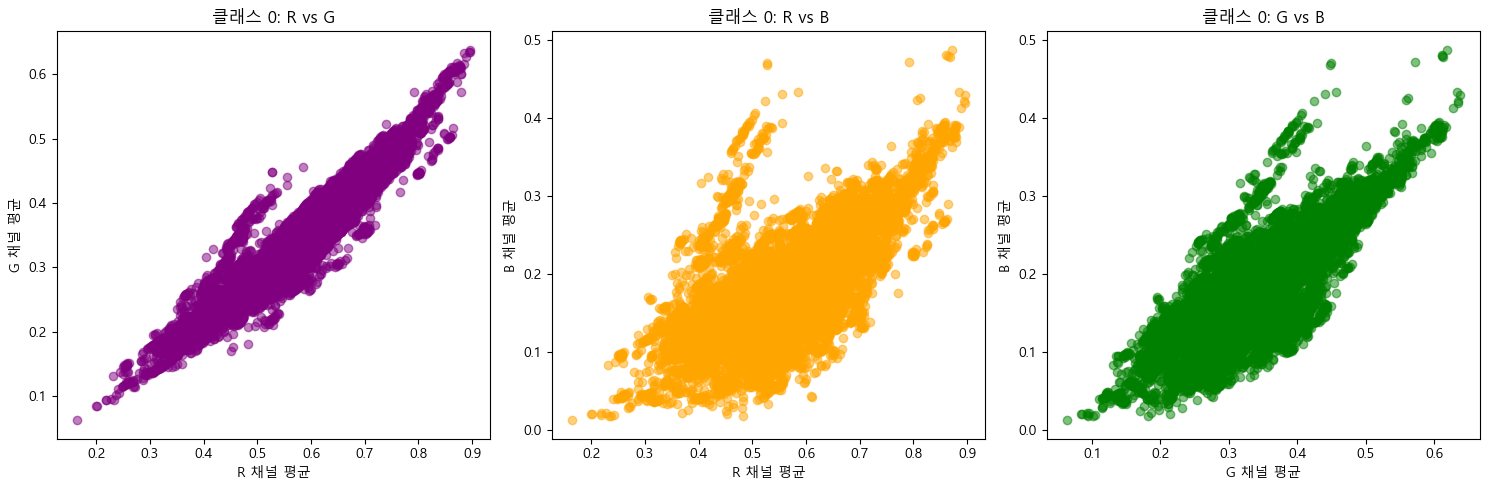

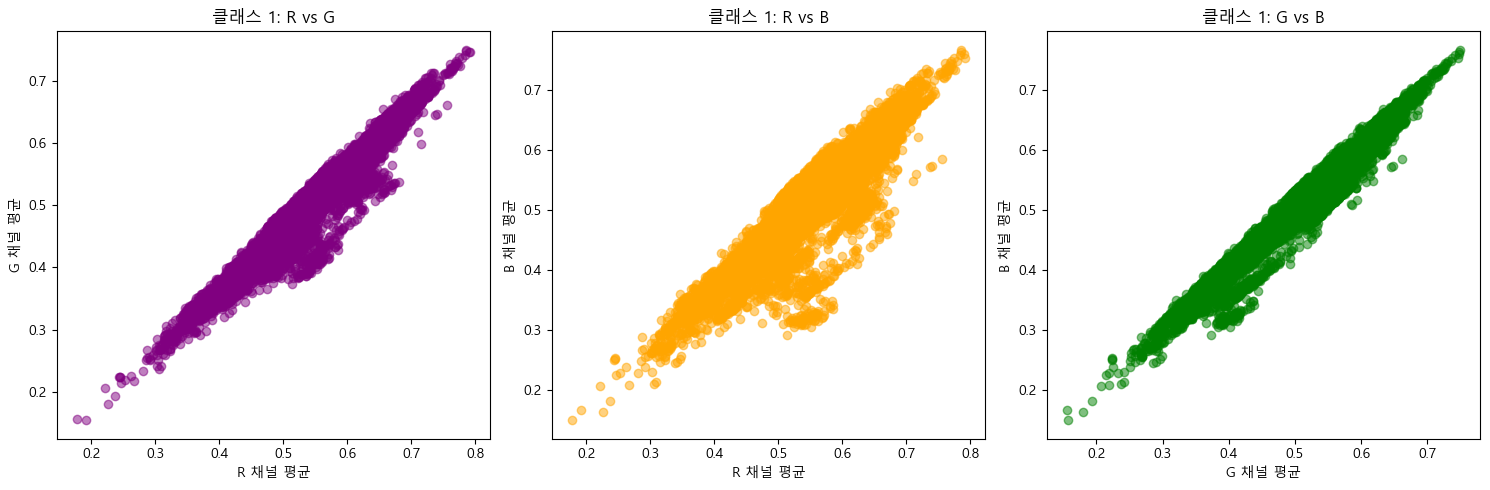

2024-11-09 06:57:47,193 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BF869F648>
2024-11-09 06:57:47,193 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BF869F648>
2024-11-09 06:57:47,193 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BF869F648>


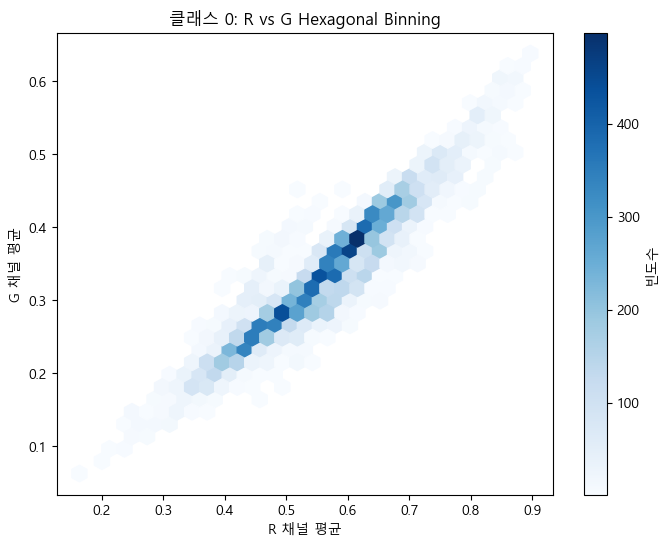

2024-11-09 06:57:47,929 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BADEF2D08>
2024-11-09 06:57:47,929 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BADEF2D08>
2024-11-09 06:57:47,929 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000025BADEF2D08>


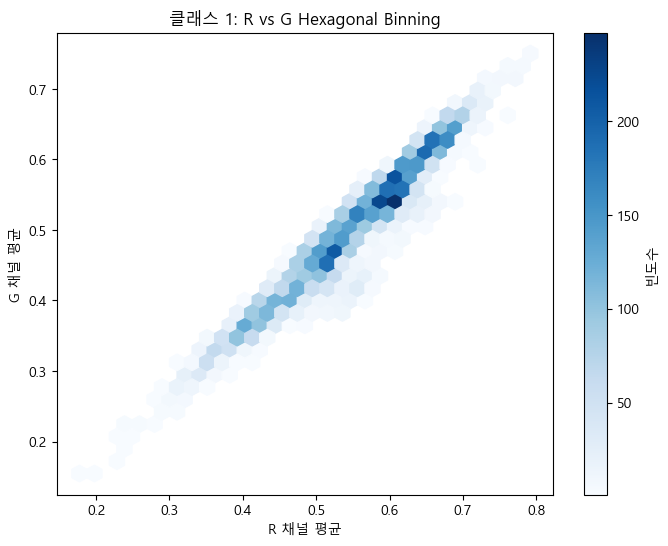

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import torch
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms
import sys
from scipy.stats import pearsonr


# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 구조 이해 및 샘플링 확인 (EDA)
def perform_eda(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터 개수 확인
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # 막대 그래프 시각화
    plt.figure(figsize=(8, 5))
    plt.bar(unique_labels, counts, tick_label=['음성', '양성'], color=['skyblue', 'salmon'])
    plt.xlabel('클래스')
    plt.ylabel('데이터 개수')
    plt.title('음성/양성 데이터 분포')
    plt.show()
    
    # 각 클래스에서 임의의 이미지 3개씩 시각화 (이미지가 3개 미만일 경우 대비)
    for label in unique_labels:
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'클래스 {label} 예시 이미지')
        label_items = [item for item in dataset if item[1] == label]
        num_images = min(3, len(label_items))
        
        for i in range(num_images):
            img_tensor = label_items[i][0]
            img = transforms.ToPILImage()(img_tensor)  # 텐서를 PIL 이미지로 변환
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'이미지 파일명: {label_items[i][2]}')
        plt.show()
    
    # 위치 추정 통계량 계산 (RGB 채널별 평균, 중앙값)
    print("\n위치 추정 통계량 (RGB 채널별):")
    for label in unique_labels:
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = []
        g_means = []
        b_means = []
        r_medians = []
        g_medians = []
        b_medians = []
        r_stds = []
        g_stds = []
        b_stds = []
        r_percentiles = []
        g_percentiles = []
        b_percentiles = []
        
        for img_tensor in label_items:
            img_array = img_tensor.numpy()  # 텐서를 넘파이 배열로 변환
            r_channel = img_array[0].flatten()
            g_channel = img_array[1].flatten()
            b_channel = img_array[2].flatten()
            
            r_means.append(np.mean(r_channel))
            g_means.append(np.mean(g_channel))
            b_means.append(np.mean(b_channel))
            
            r_medians.append(np.median(r_channel))
            g_medians.append(np.median(g_channel))
            b_medians.append(np.median(b_channel))
            
            r_stds.append(np.std(r_channel))
            g_stds.append(np.std(g_channel))
            b_stds.append(np.std(b_channel))
            
            r_percentiles.append(np.percentile(r_channel, 25))
            g_percentiles.append(np.percentile(g_channel, 25))
            b_percentiles.append(np.percentile(b_channel, 25))
        
        print(f"클래스 {label}: R 평균 = {np.mean(r_means):.4f}, G 평균 = {np.mean(g_means):.4f}, B 평균 = {np.mean(b_means):.4f}")
        print(f"클래스 {label}: R 중앙값 = {np.median(r_medians):.4f}, G 중앙값 = {np.median(g_medians):.4f}, B 중앙값 = {np.median(b_medians):.4f}")
        print(f"클래스 {label}: R 표준편차 = {np.mean(r_stds):.4f}, G 표준편차 = {np.mean(g_stds):.4f}, B 표준편차 = {np.mean(b_stds):.4f}")
        print(f"클래스 {label}: R 25번째 백분위수 = {np.mean(r_percentiles):.4f}, G 25번째 백분위수 = {np.mean(g_percentiles):.4f}, B 25번째 백분위수 = {np.mean(b_percentiles):.4f}")
    
    # Boxplot 시각화 (클래스별 RGB 채널별 평균을 수집하여 박스플롯 생성)
    for label in unique_labels:
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=[r_means, g_means, b_means], palette=['r', 'g', 'b'])
        plt.xticks([0, 1, 2], ['R 채널', 'G 채널', 'B 채널'])
        plt.title(f"클래스 {label}의 RGB 채널 Boxplot")
        plt.show()
    
    # 빈도 테이블과 히스토그램 및 밀도 추정 (클래스별 RGB 채널별 히스토그램 및 밀도 추정)
    for label in unique_labels:
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        plt.figure(figsize=(15, 5))
        sns.histplot(r_means, bins=30, color='r', kde=True, label='R 채널')
        sns.histplot(g_means, bins=30, color='g', kde=True, label='G 채널')
        sns.histplot(b_means, bins=30, color='b', kde=True, label='B 채널')
        plt.xlabel('픽셀 값 평균')
        plt.ylabel('빈도수 / 밀도 추정값')
        plt.title(f'클래스 {label}의 RGB 채널별 히스토그램 및 밀도 추정')
        plt.legend()
        plt.show()
    
    # RGB 채널 간 상관관계 (Correlation)
    for label in unique_labels:
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        df = pd.DataFrame({'R 채널 평균': r_means, 'G 채널 평균': g_means, 'B 채널 평균': b_means})
        corr_matrix = df.corr()
        print(f"클래스 {label}의 RGB 채널 간 상관계수:\n{corr_matrix}\n")
        
        # 상관 행렬 시각화
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'클래스 {label}의 RGB 채널 간 상관 행렬')
        plt.show()
    
    # RGB 채널 간 산점도 (Scatterplots)
    for label in unique_labels:
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.scatter(r_means, g_means, alpha=0.5, color='purple')
        plt.xlabel('R 채널 평균')
        plt.ylabel('G 채널 평균')
        plt.title(f'클래스 {label}: R vs G')
        
        plt.subplot(1, 3, 2)
        plt.scatter(r_means, b_means, alpha=0.5, color='orange')
        plt.xlabel('R 채널 평균')
        plt.ylabel('B 채널 평균')
        plt.title(f'클래스 {label}: R vs B')
        
        plt.subplot(1, 3, 3)
        plt.scatter(g_means, b_means, alpha=0.5, color='green')
        plt.xlabel('G 채널 평균')
        plt.ylabel('B 채널 평균')
        plt.title(f'클래스 {label}: G vs B')
        plt.tight_layout()
        plt.show()
    
    # RGB 채널 간 Hexagonal binning 시각화
    for label in unique_labels:
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        
        plt.figure(figsize=(8, 6))
        plt.hexbin(r_means, g_means, gridsize=30, cmap='Blues', mincnt=1)
        plt.xlabel('R 채널 평균')
        plt.ylabel('G 채널 평균')
        plt.title(f'클래스 {label}: R vs G Hexagonal Binning')
        plt.colorbar(label='빈도수')
        plt.show()

# EDA 수행
perform_eda(dataset)


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import torch
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms
from scipy.stats import pearsonr, norm, probplot
from tqdm import tqdm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 및 샘플링 분포 분석
def perform_data_and_sampling_distributions(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터에서 RGB 채널 평균 추출
    for label in np.unique(labels):
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        
        # RGB 채널별 평균값에 대한 샘플링 분포 시각화
        plt.figure(figsize=(15, 5))
        for i, (means, color, channel) in enumerate(zip([r_means, g_means, b_means], ['r', 'g', 'b'], ['R 채널', 'G 채널', 'B 채널'])):
            plt.subplot(1, 3, i + 1)
            sns.histplot(means, bins=30, kde=True, color=color, label=f'{channel} 평균값')
            plt.axvline(np.mean(means), color='k', linestyle='dashed', linewidth=1, label=f'{channel} 평균값')
            plt.xlabel('값')
            plt.ylabel('빈도수')
            plt.title(f'클래스 {label}의 {channel} 샘플링 분포')
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 샘플 평균 및 표준 오차 계산
        for channel, means in zip(['R 채널', 'G 채널', 'B 채널'], [r_means, g_means, b_means]):
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            print(f"클래스 {label}의 {channel} 샘플 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")
        
        # 샘플링 분포에 대한 정규분포 근사 시각화
        plt.figure(figsize=(15, 5))
        for i, (means, color, channel) in enumerate(zip([r_means, g_means, b_means], ['r', 'g', 'b'], ['R 채널', 'G 채널', 'B 채널'])):
            plt.subplot(1, 3, i + 1)
            sns.histplot(means, bins=30, kde=False, color=color, label=f'{channel} 히스토그램', alpha=0.6)
            mean = np.mean(means)
            std_dev = np.std(means)
            x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
            plt.plot(x, norm.pdf(x, mean, std_dev) * len(means) * (x[1] - x[0]), color='k', linestyle='dashed', linewidth=1, label='정규분포 근사')
            plt.xlabel('값')
            plt.ylabel('빈도수')
            plt.title(f'클래스 {label}의 {channel} 정규분포 근사')
            plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 신뢰 구간 계산 (95% 신뢰 구간)
        for channel, means in zip(['R 채널', 'G 채널', 'B 채널'], [r_means, g_means, b_means]):
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            ci_lower = sample_mean - 1.96 * sample_std_error
            ci_upper = sample_mean + 1.96 * sample_std_error
            print(f"클래스 {label}의 {channel} 95% 신뢰 구간: ({ci_lower:.4f}, {ci_upper:.4f})")
        
        # 표준 정규분포 및 QQ-플롯 시각화
        plt.figure(figsize=(15, 5))
        for i, (means, color, channel) in enumerate(zip([r_means, g_means, b_means], ['r', 'g', 'b'], ['R 채널', 'G 채널', 'B 채널'])):
            plt.subplot(1, 3, i + 1)
            probplot(means, dist="norm", plot=plt)
            plt.title(f'클래스 {label}의 {channel} QQ-플롯')
        plt.tight_layout()
        plt.show()

# 데이터 및 샘플링 분포 분석 수행
perform_data_and_sampling_distributions(dataset)




RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import torch
import seaborn as sns
import pandas as pd
import torchvision.transforms as transforms
from scipy.stats import pearsonr, norm, probplot, ttest_ind, f_oneway, chi2_contingency
from tqdm import tqdm

import sys

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우에서 사용할 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS에서 사용할 경우
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

# 데이터 및 통계적 실험과 유의성 검정 수행
def perform_statistical_experiments_and_tests(dataset):
    # 라벨 정보 추출 (음성: 0, 양성: 1)
    labels = [item[1] for item in dataset]
    
    # 라벨별 데이터에서 RGB 채널 평균 및 분산 추출
    label_data = {}
    observed_means = {}
    observed_variances = {}
    for label in np.unique(labels):
        label_items = [item[0] for item in dataset if item[1] == label]
        r_means = [np.mean(item.numpy()[0].flatten()) for item in label_items]
        g_means = [np.mean(item.numpy()[1].flatten()) for item in label_items]
        b_means = [np.mean(item.numpy()[2].flatten()) for item in label_items]
        r_variances = [np.var(item.numpy()[0].flatten()) for item in label_items]
        g_variances = [np.var(item.numpy()[1].flatten()) for item in label_items]
        b_variances = [np.var(item.numpy()[2].flatten()) for item in label_items]
        
        label_data[label] = {'R': r_means, 'G': g_means, 'B': b_means}
        observed_means[label] = {'R': np.mean(r_means), 'G': np.mean(g_means), 'B': np.mean(b_means)}
        observed_variances[label] = {'R': np.mean(r_variances), 'G': np.mean(g_variances), 'B': np.mean(b_variances)}
    
    # t-검정을 통한 클래스 간 유의성 검정
    for channel in ['R', 'G', 'B']:
        t_stat, p_value = ttest_ind(label_data[0][channel], label_data[1][channel], equal_var=False)
        df = len(label_data[0][channel]) + len(label_data[1][channel]) - 2
        var_0 = np.var(label_data[0][channel], ddof=1)
        var_1 = np.var(label_data[1][channel], ddof=1)
        print(f"{channel} 채널의 클래스 간 t-검정 결과: t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}, 자유도 = {df}, 분산(음성) = {var_0:.4f}, 분산(양성) = {var_1:.4f}")
        if p_value < 0.05:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의합니다. (p < 0.05)")
        else:
            print(f"{channel} 채널의 클래스 간 평균 차이는 통계적으로 유의하지 않습니다. (p >= 0.05)")
    
    # 샘플 평균 및 표준 오차 계산
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            print(f"클래스 {label}의 {channel} 채널 샘플 평균: {sample_mean:.4f}, 표준 오차: {sample_std_error:.4f}")
        
    # 신뢰 구간 계산 (95% 신뢰 구간)
    for label in np.unique(labels):
        for channel, means in label_data[label].items():
            sample_mean = np.mean(means)
            sample_std_error = np.std(means) / np.sqrt(len(means))
            ci_lower = sample_mean - 1.96 * sample_std_error
            ci_upper = sample_mean + 1.96 * sample_std_error
            print(f"클래스 {label}의 {channel} 채널 95% 신뢰 구간: ({ci_lower:.4f}, {ci_upper:.4f})")
    
    # RGB 채널 간 평균 비교 (분산분석)
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    # 데이터 프레임 생성 및 분산분석 수행
    for label in np.unique(labels):
        anova_data = []
        for i in range(len(label_data[label]['R'])):
            anova_data.append(['R', label_data[label]['R'][i], label])
            anova_data.append(['G', label_data[label]['G'][i], label])
            anova_data.append(['B', label_data[label]['B'][i], label])
        
        anova_df = pd.DataFrame(anova_data, columns=['Channel', 'Value', 'Label'])
        
        # 분산분석 수행
        model = smf.ols('Value ~ C(Channel)', data=anova_df).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)
        print(f"클래스 {label}의 분산분석 결과:", anova_results)

# Python 경로에 SciPy 설치 경로 추가
sys.path.append('/path/to/scipy')

# 통계적 실험과 유의성 검정 수행
perform_statistical_experiments_and_tests(dataset)
















RuntimeError: Boolean value of Tensor with more than one value is ambiguous

# 모델 설정

# 모델명: GoogleNet

In [11]:
class Inception(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수, default = 3
    use_auxiliary (boolean) : Auxiliary의 사용 여부, default = True
    num_classes (integer)   : Input dataset 의 class(label)의 개수, default = 10
    
    GoogleNet 모형의 전체 구조 구현
    '''
    def __init__(self,num_classes, in_channels=3, use_auxiliary=True):
        super(Inception, self).__init__()
        random_seed = 42
        torch.manual_seed(random_seed)
        
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1)
        
        self.dropout = nn.Dropout(0.60)
        self.linear = nn.Linear(4096, num_classes)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)
        
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None
        
        x = self.conv1(x) # 
        x = self.maxpool(x) # 
        x = self.conv2(x) # 
        x = self.maxpool(x) # 
        
        x = self.inception3a(x) # 
        x = self.inception3b(x) # 
        x = self.maxpool(x) # 
    
        x = self.inception4a(x) # 
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        
        x = self.linear(x)
        
        return x, y, z

In [12]:
class ConvBlock(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수
    out_channels (integer)  : Output dataset 의 channel 수
    kernel_size (integer) : Convolution Layer의 kernel 크기
    
    GoogleNet 모형의 Inception Module에 사용되는 Convolution Block을 구현
    '''
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        random_seed = 42
        torch.manual_seed(random_seed)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) 
        self.ReLU = nn.ReLU() #activation function 교체
        
    def forward(self, x):
        return self.ReLU(self.bn(self.conv(x)))

In [13]:
class InceptionBlock(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수
    num_1x1(integer)        : Filter의 크기가 1X1인 Convolution Block(self.one_by_one)의 출력 channel 수
    num_3x3_red(integer)    : Filter의 크기가 1X1인 Convolution Block(self.tree_by_three_red)의 출력 channel 수
    num_3x3(integer)        : Filter의 크기가 3X3인 Convolution Block(self.tree_by_three)의 출력 channel 수
    num_5x5_red(integer)    : Filter의 크기가 1X1인 Convolution Block(self.five_by_five_red)의 출력 channel 수
    num_5x5(integer)        : Filter의 크기가 5X5인 Convolution Block(self.five_by_five)의 출력 channel 수
    num_pool_proj(integer)  : Filter의 크기가 1X1인 Convolution Block(self.pool_proj)의 출력 channel 수
    
    GoogleNet 모형의 Inception Module을 구현
    '''
    def __init__(self, in_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()
        
        random_seed = 42
        torch.manual_seed(random_seed)
        
        self.one_by_one = ConvBlock(in_channels, num_1x1, kernel_size=1)
        
        self.tree_by_three_red = ConvBlock(in_channels, num_3x3_red, kernel_size=1)  
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)
        
        self.five_by_five_red = ConvBlock(in_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(in_channels, num_pool_proj, kernel_size=1)
         
    def forward(self, x):
        x1 = self.one_by_one(x)
        
        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)
        
        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)
        
        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)
        
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

In [14]:
class Auxiliary(nn.Module):
    '''
    in_channels (integer)   : Input dataset 의 channel 수          
    num_classes (integer)   : Input dataset 의 class(label)의 개수 
    
    GoogleNet 모형에서 train dataset 학습시 사용되는 Auxiliary Classifier를 구현
    '''
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        random_seed = 42
        torch.manual_seed(random_seed)
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(0.6)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.ReLU(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
class GoogleNetModel(nn.Module):
    '''
    train_dataset (dataset)         : 모형 학습에서 train dataset 로 사용할 데이터 셋
    val_dataset (dataset)           : 모형 학습에서 validation dataset 로 사용할 데이터 셋
    epoch (integer)              : 학습을 반복할 횟수
    learning_rate (float)        : 모형 학습에서 사용할 learning_rate
    batch_size (integer)         : 한 번 학습에 사용할 이미지의 개수
    loader_num_workers (integer) : DataLoader에서 사용할 코어의 개수
        
    GoogleNet 모형을 학습시키는 일련의 과정을 구현
    '''
    def __init__(self, train_dataset, val_dataset, num_classes, epoch, learning_rate, batch_size, loader_num_workers):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        random_seed = 42
        torch.manual_seed(random_seed)
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset   
        self.num_classes = num_classes
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loader_num_workers = loader_num_workers
        self.patience_i = int(min(np.ceil(epoch*1), 10))
        
        
    def GoogleNetTrain(self):
        model = Inception(num_classes = self.num_classes).to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=self.patience_i, verbose=True)
        
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.loader_num_workers)
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.loader_num_workers)
        dataloaders = {"train": train_loader, "val": val_loader}
                
        since = time.time()
        train_acc_history = []
        train_loss_history = []
        val_acc_history = []
        val_loss_history = []
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        use_auxiliary=True
        loss_sample=[]

        for i in range(self.epoch):
            epoch_time = time.time()
            print('Epoch {}/{}'.format(i+1, self.epoch), '(', datetime.datetime.now(), ')')
            logger.info('Epoch {}/{}'.format(i+1,self.epoch))
            print('-' * 10)
            logger.info('-'*10)

            for phase in ['train', 'val']: # Each epoch has a training and validation phase
                if phase == 'train':
                    logger.info('Model Training을 진행합니다.')
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    logger.info('Model을 validation을 진행합니다')

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]: # Iterate over dataset

                    inputs = inputs.to(self.device) #tensor data

                    labels = labels.to(self.device) #label값

                    optimizer.zero_grad() # Zero the parameter gradients

                    with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train

                        if phase == 'train': # Backward + optimize only if in training phase
                            if use_auxiliary:
                                outputs, aux1, aux2 = model(inputs)
                                loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
                                loss_sample.append(loss)
                            else:
                                outputs, _, _ = model(inputs)
                                loss = criterion(outputs, labels)
                                loss_sample.append(loss)

                            _, preds = torch.max(outputs, 1)
                            loss.backward() #backpropagation
                            optimizer.step() #가중치 업데이트

                        if phase == 'val':
                            outputs, _, _ = model(inputs)
                            loss = criterion(outputs, labels)
                            loss_sample.append(loss)
                            _, preds = torch.max(outputs, 1)

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)

                if phase == 'val': # Adjust learning rate based on val loss
                    lr_scheduler.step(epoch_loss)

                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), '(', datetime.datetime.now(), ')')
                #logger.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                e_time = time.time() - epoch_time

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_num = i+1
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val':
                    val_acc_history.append(float(epoch_acc))
                    val_loss_history.append(float(epoch_loss))
                if phase == 'train':
                    train_acc_history.append(float(epoch_acc))
                    train_loss_history.append(float(epoch_loss))

            print('Epoch Time : {:.0f}m {:.0f}s'.format(e_time//60, e_time%60), datetime.datetime.now(), '(', datetime.datetime.now(), ')\n')
            logger.info('Epoch Time : {:.0f}m {:0f}s'.format(e_time//60, e_time%60))

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), '(', datetime.datetime.now(), ')')
        logger.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best Model is {0}'.format(best_num), '(', datetime.datetime.now(), ')')
        logger.info('Best Model is {0}'.format(best_num))
        print('Best val Acc: {:4f}'.format(best_acc), '(', datetime.datetime.now(), ')')
        logger.info('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        
        return model, self.epoch, train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Model Training 진행

In [ ]:
print('GoogleNet train 시작', '(', datetime.datetime.now(), ')')
#logger.info('GoogleNet train 시작')

model, epoch, train_loss_history, train_acc_history, val_loss_history, val_acc_history = GoogleNetModel(train_dataset = [i[0:2] for i in traindataset],
                                                                                               val_dataset = [i[0:2] for i in valdataset],
                                                                                               num_classes = 2, epoch = 10, 
                                                                                               learning_rate = 0.1, batch_size = 32,
                                                                                               loader_num_workers = 1).GoogleNetTrain()
# if (os.path.exists('./models')==False):
#     os.makedirs('./models')
# torch.save(model, f'./models/GoogleNet.pt')
logger.info('학습을 완료한 GoogleNet모델을 저장하였습니다.')
# torch.save(model.state_dict(), f'./models/GoogleNet_stat.pt')
logger.info('학습을 완료한 GoogleNet모델의 파라미터들을 저장하였습니다.')

GoogleNet train 시작 ( 2022-12-27 10:20:16.491053 )
cuda


2022-12-27 10:20:21,073 - root - INFO - Epoch 1/10
2022-12-27 10:20:21,074 - root - INFO - ----------
2022-12-27 10:20:21,074 - root - INFO - Model Training을 진행합니다.


Epoch 1/10 ( 2022-12-27 10:20:21.073544 )
----------


# Model Test 진행

In [23]:
random_seed=42
try:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f'{device}로 Test를 진행중입니다.')
        
    else:
        device = torch.device('cpu')
        logger.info(f'{device}로 Test를 진행중입니다.')
        
except:
    device = torch.device('cpu')
    
Image.MAX_IMAGE_PIXELS = None
try:
    torch.backends.cudnn.deterministic = True    
    torch.backends.cudnn.benchmark = False 
except:
    pass
np.random.seed(random_seed)
try:
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
except:
    pass

#### Test Accuracy for classes
model = torch.load('./models/GoogleNet.pt', map_location=device)
logger.info('학습한 GoogleNet모델을 Load합니다.')
model.load_state_dict(torch.load('./models/GoogleNet_stat.pt', map_location=device))
logger.info('각 레이어에 해당하는 가중치 정보를 가져옵니다.')
model = model.to(device)

test_loader = DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0)

label_list = list()
prediction_list = list()

#### Print Result
print('GoogleNet Test 결과 출력', '(', datetime.datetime.now(), ')')
logger.info('GoogleNet Test 결과 출력')


classes = ['LA_NEG','LA_POS']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

print(f'{device}로 결과를 출력중입니다. cpu로 계산할 경우 시간이 오래 걸리니 기다려주세요.')

model.eval()
#logger.info('GoogleNet 모델의 Test를 진행합니다.')
with torch.no_grad():
    for data in test_loader:
        images, labels, _ = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs[0], 1)    

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            label_list.append(label.tolist())
            prediction_list.append(prediction.tolist())
mean = 0
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]

    print(f'Accuracy for class : {classname:7s} is {accuracy:.2f} %', '(', datetime.datetime.now(), ')')
    logger.info(f'Accuracy for class : {classname:7s} is {accuracy:2f} %')
    mean += accuracy
print(f'\nTotal classes : {mean/len(classes):.2f} %', '(', datetime.datetime.now(), ')')
logger.info(f'Total classes : {mean/len(classes):.2f} %')

2022-12-26 14:06:47,454 - root - INFO - cuda로 Test를 진행중입니다.
2022-12-26 14:06:48,034 - root - INFO - 학습한 GoogleNet모델을 Load합니다.
2022-12-26 14:06:48,246 - root - INFO - 각 레이어에 해당하는 가중치 정보를 가져옵니다.
2022-12-26 14:06:48,250 - root - INFO - GoogleNet Test 결과 출력


GoogleNet Test 결과 출력 ( 2022-12-26 14:06:48.250286 )
cuda로 결과를 출력중입니다. cpu로 계산할 경우 시간이 오래 걸리니 기다려주세요.


2022-12-26 14:07:09,596 - root - INFO - Accuracy for class : LA_NEG  is 99.695870 %
2022-12-26 14:07:09,597 - root - INFO - Accuracy for class : LA_POS  is 94.731679 %
2022-12-26 14:07:09,597 - root - INFO - Total classes : 97.21 %


Accuracy for class : LA_NEG  is 99.70 % ( 2022-12-26 14:07:09.596889 )
Accuracy for class : LA_POS  is 94.73 % ( 2022-12-26 14:07:09.597942 )

Total classes : 97.21 % ( 2022-12-26 14:07:09.597942 )


# 유효성 증빙서류 

1. 개별 결과값

2. confusion matrix

In [18]:
# 1. 개별 결과값 Test data set

test_ID=[]
for i in range(len(testdataset)):
    ID=testdataset[i][2]
    test_ID.append(ID)

    
test_ID=pd.DataFrame(test_ID)
label_data=pd.DataFrame(label_list)
pred_data=pd.DataFrame(prediction_list)

df_list=pd.concat([test_ID,label_data],axis=1)
df_list=pd.concat([df_list,pred_data],axis=1)
df_list.columns=['file_name','label','prediction']

logger.info(f'문제 당 개별 결과값을 출력합니다.')
logger.info(f'{df_list}')
df_list

# 문제당 개별 결과값 저장
logger.info(f'문제 당 개별 결과값을 {save_path}에 저장합니다.')
df_list.to_csv(save_path+'/'+'문제 당 개별 결과값.csv',encoding='cp949',index=False)

2022-12-26 12:46:21,932 - root - INFO - 문제 당 개별 결과값을 출력합니다.
2022-12-26 12:46:21,949 - root - INFO -                                file_name  label  prediction
0      01_1_R_LA_NA_20220720_05_1000.jpg      0           0
1      01_1_R_LA_NA_20220714_07_1379.jpg      0           0
2      01_1_R_LA_NA_20220714_02_1335.jpg      0           0
3      01_1_R_LA_NA_20220718_05_0139.jpg      0           0
4      01_2_R_LA_NA_20220721_02_0585.jpg      0           0
...                                  ...    ...         ...
20381  06_1_R_AA_NA_20221109_02_0914.jpg      1           1
20382  06_1_R_AA_NA_20221102_04_0641.jpg      1           1
20383  06_1_R_AA_NA_20221110_01_0602.jpg      1           1
20384  06_1_R_AA_NA_20221103_03_0267.jpg      1           1
20385  06_1_R_AA_NA_20221102_04_0028.jpg      1           1

[20386 rows x 3 columns]
2022-12-26 12:46:21,950 - root - INFO - 문제 당 개별 결과값을 C:/Users/user/Desktop/증빙서류에 저장합니다.


In [19]:
# 2. confusion matrix

cf=confusion_matrix(label_list, prediction_list)

cf=pd.DataFrame(cf).rename(index={0:'True_백묵병음성',1:'True_백묵병양성'}
                             ,columns={0:'Pred_백묵병음성',1:'pred_백묵병양성'})

logger.info(f'confusion matrix를 출력합니다. {cf}')
#계산할 때 사용된 값 저장 (Confusion matrix 기반 TP, FP, TN, FN)
cf.to_csv(save_path+'/'+'Confusion Matrix 기반 TP, FP, TN, FN(백묵병 분류 모델).csv',encoding='cp949')
logger.info(f'Counfusion matrix 기반 TP, FP, TN, FN값을 {save_path}에 저장합니다')

2022-12-26 12:46:25,772 - root - INFO - confusion matrix를 출력합니다.             Pred_백묵병음성  pred_백묵병양성
True_백묵병음성       10162          31
True_백묵병양성         537        9656
2022-12-26 12:46:25,774 - root - INFO - Counfusion matrix 기반 TP, FP, TN, FN값을 C:/Users/user/Desktop/증빙서류에 저장합니다
